In [25]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap
from models import JointLatentDiffusionMultilabel
from datasets import ChestXRay_nih_bbox
import torchvision as tv
from ldm.util import default
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from einops import rearrange, repeat
from ldm.models.diffusion.ddim import DDIMSampler


In [26]:
# config = OmegaConf.load("logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/checkpoints/last.ckpt"

config = OmegaConf.load("logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/configs/config.yaml")
config.model.params["ckpt_path"] = f"logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/checkpoints/last.ckpt"
model = JointLatentDiffusionMultilabel(**config.model.get("params", dict()))
model.sampling_method='conditional_to_x'

model.to(device)
model.eval()


JointLatentDiffusionMultilabel: Running in eps-prediction mode
DiffusionWrapper has 402.65 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/logs/compvis32x32x4_all_randomresizedcrop_Autoencoder_2024-01-17T13-15-27/checkpoints/epoch=000025.ckpt
Training JointLatentDiffusionMultilabel as an unconditional model.
Keeping EMAs of 312.
Restored from logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/checkpoints/last.ckpt with 0 missing and 0 unexpected keys
WARNING AUROC HARDCODEDDDD to 14 classes


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


JointLatentDiffusionMultilabel(
  (model): DiffusionWrapper(
    (diffusion_model): AdjustedUNet(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1280, out_features=320, bias=True)
            )
            (out_layers): Sequen

In [27]:
model.sample_grad_scale=40

In [28]:
def embed_imgs(model, data_loader, max_samples=1):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list, bbox_list, label_list = [], [], [], []

    for imgs, bbox, label in tqdm(data_loader):
        if len(imgs.shape) == 3:
            imgs = imgs[..., None]
        imgs = rearrange(imgs, 'b h w c -> b c h w')

        with torch.no_grad():
            encoder_posterior = model.encode_first_stage(imgs.cuda())
            latent = model.get_first_stage_encoding(encoder_posterior).detach()
            img_list.append(imgs.cpu())
            embed_list.append(latent.cpu())
            bbox_list.append(bbox)
            label_list.append(label)
        if max_samples is not None and len(img_list) > max_samples:
            break
    return (img_list, embed_list, bbox_list, label_list)

In [29]:
dataset = ChestXRay_nih_bbox(pick_class="Effusion")
# TODO just one sample for now, i'm not sure if loss goes properly if more 
dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

BBOX READ AS INT FIX IT


In [30]:
ret = embed_imgs(model, dl)

  1%|          | 1/153 [00:00<00:04, 33.41it/s]


In [31]:
ret[1][0].shape

torch.Size([1, 4, 32, 32])

In [32]:
for img_original, z, bbox in zip(ret[0], ret[1], ret[2]):
    num_timesteps = 1000
    n_row = 12 #number of images to show
    n_row = min(z.shape[0], n_row)
    z = z.to(model.device)

    # get diffusion row
    diffusion_row = list()
    z_start = z[:n_row]
    ts = 500
    t = repeat(torch.tensor([ts]), '1 -> b', b=n_row)
    t = t.to(model.device).long()
    noise = torch.randn_like(z_start)
    z_noisy = model.q_sample(x_start=z_start, t=t, noise=noise)
    break
z_noisy.shape, img_original.shape, bbox.shape

(torch.Size([1, 4, 32, 32]), torch.Size([1, 1, 256, 256]), torch.Size([1, 4]))

DDPM

In [33]:
shape = z_noisy.shape
samples = model.p_sample_loop(cond=None, shape = shape, original_img = z, return_intermediates=False, x_T=z_noisy, start_T=500)
x_samples = model.decode_first_stage(samples)

Sampling t:   0%|          | 1/500 [00:00<01:18,  6.38it/s]

all predictins for x pred start tensor([[0.4844, 0.3922, 0.4061, 0.4560, 0.4677, 0.4672, 0.4227, 0.6686, 0.4640,
         0.4066, 0.3919, 0.6786, 0.5729, 0.6025, 0.5960]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6686, 0.5960]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0027, device='cuda:0')
all predictins for x pred start tensor([[0.4848, 0.3948, 0.4055, 0.4567, 0.4680, 0.4673, 0.4223, 0.6679, 0.4646,
         0.4049, 0.3912, 0.6801, 0.5729, 0.6037, 0.5956]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   1%|          | 3/500 [00:00<01:17,  6.41it/s]

max grad from x tensor(0.0026, device='cuda:0')
all predictins for x pred start tensor([[0.4844, 0.3939, 0.4054, 0.4552, 0.4659, 0.4673, 0.4222, 0.6669, 0.4641,
         0.4052, 0.3909, 0.6791, 0.5718, 0.6034, 0.5958]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6669, 0.5958]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0026, device='cuda:0')


Sampling t:   1%|          | 4/500 [00:00<01:18,  6.31it/s]

all predictins for x pred start tensor([[0.4842, 0.3949, 0.4041, 0.4545, 0.4648, 0.4684, 0.4214, 0.6661, 0.4643,
         0.4052, 0.3911, 0.6807, 0.5726, 0.6045, 0.5952]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6661, 0.5952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0027, device='cuda:0')
all predictins for x pred start tensor([[0.4855, 0.3956, 0.4040, 0.4545, 0.4657, 0.4690, 0.4211, 0.6659, 0.4643,
         0.4062, 0.3915, 0.6808, 0.5737, 0.6056, 0.5953]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   1%|          | 6/500 [00:00<01:17,  6.34it/s]

max grad from x tensor(0.0028, device='cuda:0')
all predictins for x pred start tensor([[0.4856, 0.3942, 0.4039, 0.4527, 0.4648, 0.4694, 0.4214, 0.6651, 0.4640,
         0.4076, 0.3919, 0.6800, 0.5726, 0.6036, 0.5946]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6651, 0.5946]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0029, device='cuda:0')
all predictins for x pred start 

Sampling t:   1%|▏         | 7/500 [00:01<01:17,  6.39it/s]

tensor([[0.4848, 0.3940, 0.4030, 0.4525, 0.4671, 0.4679, 0.4217, 0.6643, 0.4655,
         0.4071, 0.3896, 0.6821, 0.5720, 0.6019, 0.5946]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6643, 0.5946]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0028, device='cuda:0')
all predictins for x pred start tensor([[0.4856, 0.3932, 0.4032, 0.4519, 0.4667, 0.4682, 0.4215, 0.6634, 0.4666,
         0.4077, 0.3885, 0.6834, 0.5722, 0.6016, 0.5940]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
 

Sampling t:   2%|▏         | 9/500 [00:01<01:17,  6.34it/s]

max grad from x tensor(0.0029, device='cuda:0')
all predictins for x pred start tensor([[0.4858, 0.3949, 0.4034, 0.4512, 0.4663, 0.4673, 0.4218, 0.6638, 0.4654,
         0.4068, 0.3889, 0.6816, 0.5716, 0.6015, 0.5952]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6638, 0.5952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0028, device='cuda:0')


Sampling t:   2%|▏         | 10/500 [00:01<01:17,  6.32it/s]

all predictins for x pred start tensor([[0.4856, 0.3969, 0.4042, 0.4515, 0.4676, 0.4691, 0.4224, 0.6636, 0.4671,
         0.4063, 0.3892, 0.6841, 0.5717, 0.6022, 0.5945]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6636, 0.5945]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0029, device='cuda:0')
all predictins for x pred start tensor([[0.4853, 0.3954, 0.4040, 0.4507, 0.4681, 0.4690, 0.4222, 0.6637, 0.4675,
         0.4066, 0.3891, 0.6847, 0.5713, 0.6024, 0.5943]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   2%|▏         | 12/500 [00:01<01:18,  6.23it/s]

max grad from x tensor(0.0029, device='cuda:0')
all predictins for x pred start tensor([[0.4841, 0.3936, 0.4026, 0.4502, 0.4680, 0.4680, 0.4228, 0.6647, 0.4666,
         0.4063, 0.3877, 0.6845, 0.5677, 0.6008, 0.5937]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6647, 0.5937]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0027, device='cuda:0')


Sampling t:   3%|▎         | 13/500 [00:02<01:17,  6.29it/s]

all predictins for x pred start tensor([[0.4847, 0.3913, 0.4020, 0.4499, 0.4668, 0.4678, 0.4221, 0.6620, 0.4653,
         0.4077, 0.3864, 0.6815, 0.5661, 0.6006, 0.5948]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6620, 0.5948]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0026, device='cuda:0')
all predictins for x pred start tensor([[0.4841, 0.3922, 0.4009, 0.4502, 0.4677, 0.4674, 0.4233, 0.6635, 0.4644,
         0.4061, 0.3861, 0.6826, 0.5643, 0.5995, 0.5940]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   3%|▎         | 15/500 [00:02<01:17,  6.27it/s]

max grad from x tensor(0.0030, device='cuda:0')
all predictins for x pred start tensor([[0.4861, 0.3946, 0.4015, 0.4511, 0.4702, 0.4704, 0.4230, 0.6650, 0.4648,
         0.4065, 0.3876, 0.6833, 0.5672, 0.6021, 0.5946]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6650, 0.5946]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')


Sampling t:   3%|▎         | 16/500 [00:02<01:17,  6.23it/s]

all predictins for x pred start tensor([[0.4859, 0.3962, 0.4013, 0.4533, 0.4712, 0.4704, 0.4225, 0.6654, 0.4647,
         0.4055, 0.3885, 0.6840, 0.5694, 0.6045, 0.5957]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6654, 0.5957]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')
all predictins for x pred start tensor([[0.4876, 0.3966, 0.4044, 0.4528, 0.4712, 0.4736, 0.4219, 0.6653, 0.4653,
         0.4057, 0.3913, 0.6844, 0.5728, 0.6073, 0.5975]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   4%|▎         | 18/500 [00:02<01:17,  6.24it/s]

max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4890, 0.3988, 0.4064, 0.4527, 0.4718, 0.4748, 0.4233, 0.6658, 0.4664,
         0.4062, 0.3929, 0.6845, 0.5770, 0.6092, 0.5990]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6658, 0.5990]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')


Sampling t:   4%|▍         | 19/500 [00:03<01:16,  6.33it/s]

all predictins for x pred start tensor([[0.4894, 0.4006, 0.4065, 0.4540, 0.4727, 0.4753, 0.4233, 0.6674, 0.4672,
         0.4065, 0.3932, 0.6865, 0.5796, 0.6111, 0.5992]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6674, 0.5992]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4895, 0.4014, 0.4066, 0.4565, 0.4731, 0.4738, 0.4240, 0.6696, 0.4676,
         0.4079, 0.3945, 0.6860, 0.5800, 0.6112, 0.6010]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   4%|▍         | 21/500 [00:03<01:15,  6.33it/s]

max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4894, 0.4000, 0.4065, 0.4571, 0.4718, 0.4734, 0.4227, 0.6693, 0.4674,
         0.4087, 0.3942, 0.6849, 0.5812, 0.6109, 0.6006]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6693, 0.6006]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')


Sampling t:   4%|▍         | 22/500 [00:03<01:15,  6.36it/s]

all predictins for x pred start tensor([[0.4875, 0.3978, 0.4052, 0.4562, 0.4709, 0.4735, 0.4218, 0.6667, 0.4662,
         0.4093, 0.3927, 0.6840, 0.5785, 0.6095, 0.5983]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6667, 0.5983]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')
all predictins for x pred start tensor([[0.4857, 0.3960, 0.4044, 0.4529, 0.4681, 0.4754, 0.4214, 0.6650, 0.4658,
         0.4093, 0.3916, 0.6840, 0.5753, 0.6063, 0.5946]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   5%|▍         | 24/500 [00:03<01:14,  6.41it/s]

max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4856, 0.3950, 0.4031, 0.4535, 0.4681, 0.4760, 0.4213, 0.6661, 0.4657,
         0.4088, 0.3908, 0.6853, 0.5751, 0.6061, 0.5935]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6661, 0.5935]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4856, 0.3939, 0.4008, 0.4524, 0.4676, 0.4745, 0.4207, 0.6660, 0.4654,
         0.4088, 0.3892, 0.6846, 0.5720, 0.6043, 0.5926]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:   5%|▌         | 25/500 [00:03<01:13,  6.48it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6660, 0.5926]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.4851, 0.3938, 0.4005, 0.4517, 0.4680, 0.4736, 0.4214, 0.6676, 0.4645,
         0.4088, 0.3891, 0.6844, 0.5704, 0.6013, 0.5914]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6676, 0.5914]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:   5%|▌         | 27/500 [00:04<01:13,  6.45it/s]

max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4849, 0.3919, 0.4004, 0.4498, 0.4672, 0.4745, 0.4214, 0.6654, 0.4638,
         0.4092, 0.3886, 0.6827, 0.5680, 0.5999, 0.5895]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6654, 0.5895]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start 

Sampling t:   6%|▌         | 28/500 [00:04<01:12,  6.49it/s]

tensor([[0.4850, 0.3896, 0.4010, 0.4483, 0.4675, 0.4744, 0.4206, 0.6632, 0.4634,
         0.4100, 0.3872, 0.6819, 0.5682, 0.5988, 0.5876]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6632, 0.5876]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4849, 0.3883, 0.4003, 0.4467, 0.4667, 0.4748, 0.4206, 0.6617, 0.4617,
         0.4102, 0.3851, 0.6796, 0.5656, 0.5973, 0.5859]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
 

Sampling t:   6%|▌         | 30/500 [00:04<01:12,  6.50it/s]

max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4846, 0.3866, 0.3996, 0.4463, 0.4643, 0.4759, 0.4185, 0.6627, 0.4610,
         0.4111, 0.3841, 0.6794, 0.5650, 0.5963, 0.5855]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6627, 0.5855]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4848, 0.3845, 0.3995, 0.4458, 0.4651, 0.4765, 0.4175, 0.6602, 0.4610,
         0.4113, 0.3833, 0.6798, 0.5668, 0.5969, 0.5856]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:   6%|▌         | 31/500 [00:04<01:12,  6.50it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6602, 0.5856]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4847, 0.3840, 0.4000, 0.4460, 0.4652, 0.4753, 0.4158, 0.6593, 0.4626,
         0.4121, 0.3832, 0.6787, 0.5691, 0.5961, 0.5865]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6593, 0.5865]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:   7%|▋         | 33/500 [00:05<01:12,  6.42it/s]

max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4847, 0.3830, 0.4000, 0.4458, 0.4645, 0.4764, 0.4171, 0.6594, 0.4625,
         0.4121, 0.3827, 0.6789, 0.5689, 0.5968, 0.5878]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6594, 0.5878]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')


Sampling t:   7%|▋         | 34/500 [00:05<01:12,  6.41it/s]

all predictins for x pred start tensor([[0.4848, 0.3842, 0.3998, 0.4476, 0.4649, 0.4772, 0.4162, 0.6586, 0.4640,
         0.4120, 0.3829, 0.6809, 0.5698, 0.5991, 0.5872]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6586, 0.5872]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.4857, 0.3856, 0.4014, 0.4463, 0.4645, 0.4778, 0.4179, 0.6569, 0.4641,
         0.4121, 0.3835, 0.6810, 0.5684, 0.5986, 0.5863]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:   7%|▋         | 36/500 [00:05<01:11,  6.53it/s]

max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4864, 0.3874, 0.4025, 0.4463, 0.4638, 0.4785, 0.4186, 0.6573, 0.4634,
         0.4121, 0.3849, 0.6801, 0.5671, 0.5994, 0.5860]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6573, 0.5860]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4861, 0.3877, 0.4021, 0.4453, 0.4649, 0.4761, 0.4173, 0.6553, 0.4639,
         0.4119, 0.3835, 0.6802, 0.5677, 0.5995, 0.5867]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:   7%|▋         | 37/500 [00:05<01:11,  6.46it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6553, 0.5867]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4870, 0.3886, 0.4025, 0.4450, 0.4636, 0.4775, 0.4164, 0.6556, 0.4637,
         0.4126, 0.3851, 0.6798, 0.5672, 0.5982, 0.5868]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6556, 0.5868]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:   8%|▊         | 39/500 [00:06<01:11,  6.44it/s]

max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4873, 0.3883, 0.4017, 0.4449, 0.4633, 0.4775, 0.4160, 0.6563, 0.4637,
         0.4124, 0.3846, 0.6791, 0.5668, 0.5971, 0.5862]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6563, 0.5862]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')


Sampling t:   8%|▊         | 40/500 [00:06<01:18,  5.89it/s]

all predictins for x pred start tensor([[0.4878, 0.3883, 0.4004, 0.4462, 0.4635, 0.4775, 0.4174, 0.6561, 0.4633,
         0.4125, 0.3839, 0.6792, 0.5653, 0.5961, 0.5861]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6561, 0.5861]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4880, 0.3877, 0.3996, 0.4460, 0.4638, 0.4778, 0.4170, 0.6544, 0.4631,
         0.4132, 0.3833, 0.6780, 0.5646, 0.5951, 0.5854]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:   8%|▊         | 41/500 [00:06<01:21,  5.65it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6544, 0.5854]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4893, 0.3869, 0.3994, 0.4465, 0.4648, 0.4777, 0.4175, 0.6538, 0.4634,
         0.4130, 0.3823, 0.6773, 0.5668, 0.5959, 0.5858]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6538, 0.5858]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:   9%|▊         | 43/500 [00:06<01:24,  5.41it/s]

max grad from x tensor(0.0033, device='cuda:0')
all predictins for x pred start tensor([[0.4900, 0.3878, 0.3996, 0.4466, 0.4651, 0.4776, 0.4186, 0.6528, 0.4642,
         0.4128, 0.3833, 0.6782, 0.5690, 0.5982, 0.5871]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6528, 0.5871]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')


Sampling t:   9%|▉         | 44/500 [00:07<01:25,  5.33it/s]

all predictins for x pred start tensor([[0.4903, 0.3897, 0.4002, 0.4468, 0.4655, 0.4779, 0.4196, 0.6540, 0.4646,
         0.4116, 0.3839, 0.6797, 0.5704, 0.5989, 0.5878]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6540, 0.5878]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')
all predictins for x pred start tensor([[0.4917, 0.3901, 0.4026, 0.4457, 0.4657, 0.4786, 0.4203, 0.6545, 0.4662,
         0.4113, 0.3850, 0.6806, 0.5726, 0.6005, 0.5894]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:   9%|▉         | 45/500 [00:07<01:26,  5.25it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6545, 0.5894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4920, 0.3918, 0.4039, 0.4487, 0.4671, 0.4813, 0.4222, 0.6560, 0.4682,
         0.4121, 0.3876, 0.6836, 0.5773, 0.6037, 0.5926]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6560, 0.5926]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:   9%|▉         | 47/500 [00:07<01:26,  5.22it/s]

max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4938, 0.3918, 0.4057, 0.4503, 0.4680, 0.4850, 0.4243, 0.6565, 0.4704,
         0.4130, 0.3906, 0.6872, 0.5816, 0.6072, 0.5951]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6565, 0.5951]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')


Sampling t:  10%|▉         | 48/500 [00:07<01:27,  5.19it/s]

all predictins for x pred start tensor([[0.4943, 0.3928, 0.4062, 0.4511, 0.4697, 0.4874, 0.4253, 0.6579, 0.4713,
         0.4130, 0.3908, 0.6890, 0.5816, 0.6082, 0.5949]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6579, 0.5949]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.4935, 0.3914, 0.4051, 0.4497, 0.4690, 0.4877, 0.4238, 0.6551, 0.4715,
         0.4125, 0.3897, 0.6892, 0.5807, 0.6069, 0.5931]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  10%|▉         | 49/500 [00:08<01:27,  5.18it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6551, 0.5931]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4929, 0.3908, 0.4034, 0.4487, 0.4689, 0.4859, 0.4245, 0.6546, 0.4707,
         0.4113, 0.3880, 0.6894, 0.5771, 0.6041, 0.5900]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6546, 0.5900]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  10%|█         | 51/500 [00:08<01:26,  5.18it/s]

max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4914, 0.3908, 0.4020, 0.4493, 0.4687, 0.4869, 0.4226, 0.6534, 0.4709,
         0.4111, 0.3861, 0.6886, 0.5765, 0.6022, 0.5885]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6534, 0.5885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')


Sampling t:  10%|█         | 52/500 [00:08<01:26,  5.15it/s]

all predictins for x pred start tensor([[0.4918, 0.3929, 0.4008, 0.4504, 0.4687, 0.4856, 0.4228, 0.6538, 0.4704,
         0.4102, 0.3855, 0.6882, 0.5746, 0.6016, 0.5878]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6538, 0.5878]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.4912, 0.3915, 0.4007, 0.4496, 0.4675, 0.4851, 0.4226, 0.6535, 0.4701,
         0.4105, 0.3844, 0.6872, 0.5739, 0.6014, 0.5871]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  11%|█         | 53/500 [00:08<01:26,  5.14it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6535, 0.5871]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4915, 0.3916, 0.4010, 0.4503, 0.4668, 0.4872, 0.4227, 0.6543, 0.4705,
         0.4097, 0.3855, 0.6871, 0.5738, 0.6015, 0.5864]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6543, 0.5864]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  11%|█         | 55/500 [00:09<01:26,  5.16it/s]

max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.4918, 0.3926, 0.4014, 0.4500, 0.4678, 0.4886, 0.4231, 0.6544, 0.4714,
         0.4096, 0.3860, 0.6878, 0.5759, 0.6029, 0.5864]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6544, 0.5864]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')


Sampling t:  11%|█         | 56/500 [00:09<01:26,  5.15it/s]

all predictins for x pred start tensor([[0.4932, 0.3928, 0.4020, 0.4498, 0.4678, 0.4894, 0.4243, 0.6544, 0.4724,
         0.4099, 0.3866, 0.6870, 0.5779, 0.6027, 0.5872]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6544, 0.5872]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4918, 0.3939, 0.4025, 0.4501, 0.4679, 0.4891, 0.4249, 0.6555, 0.4730,
         0.4100, 0.3869, 0.6880, 0.5771, 0.6007, 0.5879]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  11%|█▏        | 57/500 [00:09<01:26,  5.12it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6555, 0.5879]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.4911, 0.3946, 0.4021, 0.4505, 0.4682, 0.4875, 0.4249, 0.6553, 0.4729,
         0.4100, 0.3867, 0.6872, 0.5755, 0.6006, 0.5878]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6553, 0.5878]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  12%|█▏        | 59/500 [00:10<01:25,  5.18it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.4908, 0.3948, 0.4005, 0.4496, 0.4677, 0.4863, 0.4242, 0.6542, 0.4726,
         0.4101, 0.3851, 0.6863, 0.5727, 0.5990, 0.5871]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6542, 0.5871]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')


Sampling t:  12%|█▏        | 60/500 [00:10<01:25,  5.17it/s]

all predictins for x pred start tensor([[0.4910, 0.3961, 0.4007, 0.4498, 0.4666, 0.4862, 0.4236, 0.6516, 0.4739,
         0.4102, 0.3842, 0.6849, 0.5745, 0.5962, 0.5871]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6516, 0.5871]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4902, 0.3974, 0.4014, 0.4496, 0.4664, 0.4873, 0.4241, 0.6507, 0.4747,
         0.4102, 0.3848, 0.6862, 0.5744, 0.5961, 0.5862]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  12%|█▏        | 61/500 [00:10<01:25,  5.13it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6507, 0.5862]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4915, 0.3967, 0.4026, 0.4494, 0.4688, 0.4890, 0.4240, 0.6486, 0.4738,
         0.4120, 0.3842, 0.6841, 0.5750, 0.5976, 0.5867]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6486, 0.5867]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  13%|█▎        | 63/500 [00:10<01:25,  5.14it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.4925, 0.3969, 0.4029, 0.4503, 0.4699, 0.4882, 0.4236, 0.6476, 0.4743,
         0.4128, 0.3830, 0.6851, 0.5764, 0.5979, 0.5885]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6476, 0.5885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')


Sampling t:  13%|█▎        | 64/500 [00:10<01:24,  5.14it/s]

all predictins for x pred start tensor([[0.4923, 0.3978, 0.4017, 0.4526, 0.4709, 0.4874, 0.4244, 0.6475, 0.4742,
         0.4123, 0.3827, 0.6842, 0.5759, 0.5971, 0.5891]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6475, 0.5891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4932, 0.3973, 0.4013, 0.4548, 0.4724, 0.4894, 0.4235, 0.6470, 0.4755,
         0.4138, 0.3826, 0.6842, 0.5778, 0.5968, 0.5901]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  13%|█▎        | 65/500 [00:11<01:24,  5.13it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6470, 0.5901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4931, 0.3956, 0.4012, 0.4548, 0.4722, 0.4889, 0.4224, 0.6452, 0.4751,
         0.4148, 0.3828, 0.6833, 0.5783, 0.5976, 0.5893]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6452, 0.5893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  13%|█▎        | 67/500 [00:11<01:24,  5.13it/s]

max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4918, 0.3957, 0.3995, 0.4557, 0.4716, 0.4894, 0.4219, 0.6444, 0.4742,
         0.4143, 0.3814, 0.6823, 0.5753, 0.5970, 0.5895]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6444, 0.5895]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  14%|█▎        | 68/500 [00:11<01:24,  5.12it/s]

all predictins for x pred start tensor([[0.4935, 0.3974, 0.3992, 0.4575, 0.4746, 0.4883, 0.4234, 0.6441, 0.4757,
         0.4141, 0.3821, 0.6848, 0.5779, 0.5977, 0.5892]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6441, 0.5892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4948, 0.3979, 0.3991, 0.4578, 0.4771, 0.4863, 0.4233, 0.6432, 0.4756,
         0.4139, 0.3821, 0.6839, 0.5801, 0.5977, 0.5900]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  14%|█▍        | 69/500 [00:11<01:24,  5.11it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6432, 0.5900]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4942, 0.3994, 0.3985, 0.4565, 0.4754, 0.4866, 0.4225, 0.6444, 0.4753,
         0.4129, 0.3828, 0.6844, 0.5806, 0.5971, 0.5898]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6444, 0.5898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  14%|█▍        | 71/500 [00:12<01:22,  5.18it/s]

max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4952, 0.4006, 0.3976, 0.4591, 0.4769, 0.4842, 0.4215, 0.6435, 0.4749,
         0.4132, 0.3821, 0.6850, 0.5813, 0.5992, 0.5901]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6435, 0.5901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')


Sampling t:  14%|█▍        | 72/500 [00:12<01:23,  5.15it/s]

all predictins for x pred start tensor([[0.4963, 0.4011, 0.3980, 0.4593, 0.4759, 0.4815, 0.4209, 0.6439, 0.4742,
         0.4148, 0.3834, 0.6832, 0.5824, 0.6008, 0.5920]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6439, 0.5920]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4963, 0.4006, 0.3962, 0.4603, 0.4762, 0.4789, 0.4196, 0.6438, 0.4730,
         0.4150, 0.3812, 0.6838, 0.5806, 0.5996, 0.5910]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  15%|█▍        | 73/500 [00:12<01:23,  5.14it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6438, 0.5910]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4955, 0.3994, 0.3944, 0.4579, 0.4742, 0.4775, 0.4182, 0.6435, 0.4711,
         0.4135, 0.3790, 0.6829, 0.5769, 0.5975, 0.5874]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6435, 0.5874]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  15%|█▌        | 75/500 [00:13<01:22,  5.16it/s]

max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.4930, 0.3982, 0.3925, 0.4558, 0.4734, 0.4760, 0.4182, 0.6419, 0.4705,
         0.4119, 0.3760, 0.6815, 0.5710, 0.5931, 0.5845]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6419, 0.5845]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')


Sampling t:  15%|█▌        | 76/500 [00:13<01:22,  5.15it/s]

all predictins for x pred start tensor([[0.4910, 0.3970, 0.3902, 0.4555, 0.4729, 0.4772, 0.4172, 0.6403, 0.4695,
         0.4119, 0.3733, 0.6803, 0.5679, 0.5925, 0.5827]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6403, 0.5827]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0033, device='cuda:0')


Sampling t:  15%|█▌        | 77/500 [00:13<01:23,  5.06it/s]

all predictins for x pred start tensor([[0.4921, 0.3983, 0.3907, 0.4556, 0.4729, 0.4769, 0.4170, 0.6399, 0.4692,
         0.4117, 0.3752, 0.6791, 0.5683, 0.5927, 0.5830]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6399, 0.5830]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')
all predictins for x pred start tensor([[0.4930, 0.3993, 0.3909, 0.4574, 0.4745, 0.4767, 0.4170, 0.6395, 0.4698,
         0.4126, 0.3766, 0.6798, 0.5702, 0.5950, 0.5854]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  16%|█▌        | 78/500 [00:13<01:23,  5.08it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6395, 0.5854]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')
all predictins for x pred start tensor([[0.4934, 0.4001, 0.3912, 0.4596, 0.4771, 0.4774, 0.4189, 0.6388, 0.4706,
         0.4137, 0.3783, 0.6804, 0.5720, 0.5968, 0.5872]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6388, 0.5872]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  16%|█▌        | 79/500 [00:13<01:22,  5.11it/s]

max grad from x tensor(0.0031, device='cuda:0')
all predictins for x pred start tensor([[0.4957, 0.4013, 0.3916, 0.4610, 0.4781, 0.4789, 0.4185, 0.6388, 0.4718,
         0.4146, 0.3789, 0.6797, 0.5740, 0.5976, 0.5884]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6388, 0.5884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')


Sampling t:  16%|█▌        | 81/500 [00:14<01:21,  5.15it/s]

all predictins for x pred start tensor([[0.4969, 0.4009, 0.3907, 0.4617, 0.4787, 0.4786, 0.4168, 0.6377, 0.4710,
         0.4149, 0.3787, 0.6781, 0.5743, 0.5982, 0.5888]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6377, 0.5888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')
all predictins for x pred start tensor([[0.4968, 0.3997, 0.3903, 0.4617, 0.4792, 0.4768, 0.4163, 0.6368, 0.4697,
         0.4151, 0.3792, 0.6779, 0.5733, 0.5975, 0.5881]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  16%|█▋        | 82/500 [00:14<01:19,  5.23it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6368, 0.5881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0033, device='cuda:0')
all predictins for x pred start tensor([[0.4967, 0.4013, 0.3896, 0.4627, 0.4801, 0.4769, 0.4163, 0.6362, 0.4691,
         0.4143, 0.3789, 0.6788, 0.5734, 0.5983, 0.5876]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6362, 0.5876]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  17%|█▋        | 84/500 [00:14<01:18,  5.32it/s]

max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4959, 0.4012, 0.3890, 0.4639, 0.4804, 0.4754, 0.4167, 0.6364, 0.4690,
         0.4132, 0.3788, 0.6798, 0.5740, 0.5994, 0.5870]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6364, 0.5870]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')


Sampling t:  17%|█▋        | 85/500 [00:15<01:17,  5.35it/s]

all predictins for x pred start tensor([[0.4960, 0.4001, 0.3880, 0.4639, 0.4801, 0.4733, 0.4172, 0.6333, 0.4684,
         0.4126, 0.3770, 0.6788, 0.5724, 0.5983, 0.5867]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6333, 0.5867]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4952, 0.3989, 0.3884, 0.4637, 0.4782, 0.4748, 0.4175, 0.6321, 0.4687,
         0.4131, 0.3777, 0.6788, 0.5729, 0.5971, 0.5855]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  17%|█▋        | 86/500 [00:15<01:17,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6321, 0.5855]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4945, 0.3964, 0.3882, 0.4628, 0.4781, 0.4748, 0.4170, 0.6287, 0.4678,
         0.4135, 0.3776, 0.6786, 0.5714, 0.5979, 0.5850]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6287, 0.5850]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  18%|█▊        | 88/500 [00:15<01:16,  5.39it/s]

max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4942, 0.3956, 0.3882, 0.4618, 0.4773, 0.4766, 0.4172, 0.6298, 0.4675,
         0.4140, 0.3773, 0.6781, 0.5694, 0.5963, 0.5827]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6298, 0.5827]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')


Sampling t:  18%|█▊        | 89/500 [00:15<01:16,  5.38it/s]

all predictins for x pred start tensor([[0.4961, 0.3949, 0.3883, 0.4614, 0.4784, 0.4764, 0.4188, 0.6318, 0.4678,
         0.4140, 0.3766, 0.6780, 0.5693, 0.5960, 0.5826]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6318, 0.5826]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.4972, 0.3945, 0.3894, 0.4621, 0.4786, 0.4751, 0.4189, 0.6309, 0.4677,
         0.4143, 0.3782, 0.6781, 0.5724, 0.5964, 0.5849]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  18%|█▊        | 90/500 [00:15<01:16,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6309, 0.5849]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4978, 0.3950, 0.3911, 0.4643, 0.4790, 0.4756, 0.4182, 0.6330, 0.4700,
         0.4152, 0.3805, 0.6802, 0.5748, 0.5988, 0.5864]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6330, 0.5864]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  18%|█▊        | 92/500 [00:16<01:16,  5.36it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.4971, 0.3979, 0.3929, 0.4659, 0.4793, 0.4787, 0.4195, 0.6352, 0.4723,
         0.4155, 0.3834, 0.6818, 0.5773, 0.6006, 0.5867]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6352, 0.5867]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')


Sampling t:  19%|█▊        | 93/500 [00:16<01:15,  5.37it/s]

all predictins for x pred start tensor([[0.4979, 0.3983, 0.3941, 0.4658, 0.4806, 0.4815, 0.4205, 0.6342, 0.4730,
         0.4175, 0.3855, 0.6812, 0.5784, 0.6027, 0.5881]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6342, 0.5881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4988, 0.3984, 0.3949, 0.4650, 0.4802, 0.4811, 0.4211, 0.6345, 0.4723,
         0.4174, 0.3867, 0.6810, 0.5788, 0.6025, 0.5876]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  19%|█▉        | 94/500 [00:16<01:15,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6345, 0.5876]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4988, 0.3994, 0.3955, 0.4649, 0.4794, 0.4820, 0.4211, 0.6363, 0.4723,
         0.4183, 0.3866, 0.6805, 0.5774, 0.6031, 0.5878]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6363, 0.5878]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  19%|█▉        | 96/500 [00:17<01:14,  5.39it/s]

max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4991, 0.4007, 0.3950, 0.4668, 0.4815, 0.4813, 0.4208, 0.6369, 0.4727,
         0.4185, 0.3864, 0.6816, 0.5772, 0.6034, 0.5892]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6369, 0.5892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')


Sampling t:  19%|█▉        | 97/500 [00:17<01:14,  5.39it/s]

all predictins for x pred start tensor([[0.4987, 0.4014, 0.3967, 0.4665, 0.4815, 0.4838, 0.4210, 0.6366, 0.4738,
         0.4190, 0.3890, 0.6825, 0.5787, 0.6035, 0.5902]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6366, 0.5902]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4982, 0.4018, 0.3956, 0.4668, 0.4810, 0.4844, 0.4216, 0.6342, 0.4740,
         0.4176, 0.3880, 0.6839, 0.5777, 0.6038, 0.5897]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  20%|█▉        | 98/500 [00:17<01:14,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6342, 0.5897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4976, 0.4001, 0.3953, 0.4645, 0.4799, 0.4870, 0.4221, 0.6327, 0.4728,
         0.4189, 0.3884, 0.6853, 0.5747, 0.6021, 0.5889]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6327, 0.5889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  20%|██        | 100/500 [00:17<01:13,  5.41it/s]

max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.4978, 0.4012, 0.3948, 0.4647, 0.4812, 0.4847, 0.4226, 0.6317, 0.4728,
         0.4180, 0.3876, 0.6852, 0.5748, 0.5997, 0.5886]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6317, 0.5886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')


Sampling t:  20%|██        | 101/500 [00:18<01:13,  5.40it/s]

all predictins for x pred start tensor([[0.4979, 0.4022, 0.3948, 0.4661, 0.4832, 0.4843, 0.4220, 0.6302, 0.4736,
         0.4192, 0.3868, 0.6848, 0.5742, 0.5967, 0.5890]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6302, 0.5890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4984, 0.4034, 0.3961, 0.4655, 0.4827, 0.4854, 0.4227, 0.6305, 0.4745,
         0.4195, 0.3882, 0.6848, 0.5754, 0.5969, 0.5887]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  20%|██        | 102/500 [00:18<01:14,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6305, 0.5887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4986, 0.4028, 0.3957, 0.4654, 0.4824, 0.4883, 0.4242, 0.6309, 0.4742,
         0.4213, 0.3887, 0.6846, 0.5747, 0.5984, 0.5885]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6309, 0.5885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  21%|██        | 104/500 [00:18<01:14,  5.35it/s]

max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.5002, 0.4017, 0.3952, 0.4645, 0.4807, 0.4887, 0.4232, 0.6305, 0.4746,
         0.4211, 0.3882, 0.6854, 0.5751, 0.5986, 0.5884]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6305, 0.5884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')


Sampling t:  21%|██        | 105/500 [00:18<01:13,  5.35it/s]

all predictins for x pred start tensor([[0.5003, 0.4026, 0.3956, 0.4639, 0.4801, 0.4903, 0.4236, 0.6321, 0.4747,
         0.4213, 0.3888, 0.6853, 0.5750, 0.5998, 0.5886]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6321, 0.5886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0033, device='cuda:0')
all predictins for x pred start tensor([[0.5020, 0.4038, 0.3955, 0.4640, 0.4811, 0.4924, 0.4237, 0.6325, 0.4746,
         0.4220, 0.3892, 0.6834, 0.5753, 0.6013, 0.5897]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  21%|██        | 106/500 [00:18<01:13,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6325, 0.5897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5020, 0.4027, 0.3939, 0.4644, 0.4816, 0.4924, 0.4238, 0.6327, 0.4737,
         0.4217, 0.3882, 0.6816, 0.5730, 0.6018, 0.5890]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6327, 0.5890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  22%|██▏       | 108/500 [00:19<01:13,  5.32it/s]

max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.5034, 0.4024, 0.3944, 0.4646, 0.4827, 0.4928, 0.4228, 0.6319, 0.4737,
         0.4223, 0.3873, 0.6799, 0.5727, 0.6024, 0.5893]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6319, 0.5893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')


Sampling t:  22%|██▏       | 109/500 [00:19<01:13,  5.33it/s]

all predictins for x pred start tensor([[0.5037, 0.4026, 0.3945, 0.4633, 0.4813, 0.4926, 0.4228, 0.6316, 0.4729,
         0.4225, 0.3868, 0.6792, 0.5716, 0.6004, 0.5882]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6316, 0.5882]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5044, 0.4035, 0.3945, 0.4639, 0.4829, 0.4913, 0.4242, 0.6295, 0.4731,
         0.4217, 0.3872, 0.6808, 0.5719, 0.6009, 0.5874]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  22%|██▏       | 110/500 [00:19<01:13,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6295, 0.5874]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.5055, 0.4036, 0.3943, 0.4640, 0.4821, 0.4926, 0.4247, 0.6294, 0.4729,
         0.4213, 0.3872, 0.6793, 0.5708, 0.6005, 0.5872]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6294, 0.5872]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  22%|██▏       | 112/500 [00:20<01:12,  5.36it/s]

max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5050, 0.4039, 0.3940, 0.4650, 0.4830, 0.4912, 0.4253, 0.6267, 0.4724,
         0.4206, 0.3870, 0.6800, 0.5697, 0.5992, 0.5874]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6267, 0.5874]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')


Sampling t:  23%|██▎       | 113/500 [00:20<01:12,  5.36it/s]

all predictins for x pred start tensor([[0.5052, 0.4048, 0.3944, 0.4666, 0.4849, 0.4906, 0.4263, 0.6279, 0.4720,
         0.4206, 0.3873, 0.6805, 0.5691, 0.5988, 0.5886]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6279, 0.5886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5065, 0.4057, 0.3959, 0.4673, 0.4852, 0.4912, 0.4247, 0.6277, 0.4729,
         0.4212, 0.3881, 0.6794, 0.5703, 0.5993, 0.5893]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  23%|██▎       | 114/500 [00:20<01:11,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6277, 0.5893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.5067, 0.4057, 0.3954, 0.4677, 0.4865, 0.4895, 0.4240, 0.6264, 0.4729,
         0.4207, 0.3873, 0.6794, 0.5701, 0.5993, 0.5904]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6264, 0.5904]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  23%|██▎       | 116/500 [00:20<01:11,  5.37it/s]

max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5069, 0.4058, 0.3946, 0.4681, 0.4862, 0.4878, 0.4236, 0.6256, 0.4726,
         0.4211, 0.3863, 0.6785, 0.5700, 0.5971, 0.5905]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6256, 0.5905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')


Sampling t:  23%|██▎       | 117/500 [00:20<01:11,  5.36it/s]

all predictins for x pred start tensor([[0.5057, 0.4063, 0.3945, 0.4679, 0.4851, 0.4865, 0.4244, 0.6267, 0.4727,
         0.4208, 0.3861, 0.6788, 0.5685, 0.5945, 0.5904]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6267, 0.5904]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.5066, 0.4058, 0.3947, 0.4676, 0.4840, 0.4867, 0.4244, 0.6265, 0.4723,
         0.4213, 0.3879, 0.6788, 0.5695, 0.5940, 0.5903]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  24%|██▎       | 118/500 [00:21<01:11,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6265, 0.5903]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5087, 0.4055, 0.3961, 0.4678, 0.4839, 0.4873, 0.4246, 0.6246, 0.4730,
         0.4225, 0.3879, 0.6781, 0.5716, 0.5949, 0.5919]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6246, 0.5919]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  24%|██▍       | 120/500 [00:21<01:11,  5.34it/s]

max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.5086, 0.4048, 0.3943, 0.4675, 0.4844, 0.4867, 0.4250, 0.6224, 0.4724,
         0.4216, 0.3872, 0.6781, 0.5693, 0.5943, 0.5914]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6224, 0.5914]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')


Sampling t:  24%|██▍       | 121/500 [00:21<01:11,  5.34it/s]

all predictins for x pred start tensor([[0.5087, 0.4047, 0.3933, 0.4682, 0.4837, 0.4870, 0.4260, 0.6222, 0.4728,
         0.4206, 0.3871, 0.6787, 0.5679, 0.5938, 0.5911]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6222, 0.5911]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')
all predictins for x pred start tensor([[0.5073, 0.4038, 0.3924, 0.4686, 0.4827, 0.4879, 0.4255, 0.6214, 0.4724,
         0.4197, 0.3865, 0.6778, 0.5660, 0.5927, 0.5904]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  24%|██▍       | 122/500 [00:21<01:10,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6214, 0.5904]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.5083, 0.4040, 0.3926, 0.4680, 0.4819, 0.4879, 0.4264, 0.6217, 0.4728,
         0.4194, 0.3874, 0.6781, 0.5667, 0.5931, 0.5909]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6217, 0.5909]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  25%|██▍       | 124/500 [00:22<01:09,  5.38it/s]

max grad from x tensor(0.0032, device='cuda:0')
all predictins for x pred start tensor([[0.5081, 0.4052, 0.3927, 0.4676, 0.4821, 0.4887, 0.4276, 0.6242, 0.4732,
         0.4199, 0.3887, 0.6799, 0.5663, 0.5927, 0.5915]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6242, 0.5915]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0030, device='cuda:0')


Sampling t:  25%|██▌       | 125/500 [00:22<01:09,  5.39it/s]

all predictins for x pred start tensor([[0.5086, 0.4058, 0.3923, 0.4670, 0.4810, 0.4895, 0.4273, 0.6236, 0.4738,
         0.4202, 0.3892, 0.6797, 0.5664, 0.5909, 0.5911]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6236, 0.5911]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')
all predictins for x pred start tensor([[0.5081, 0.4052, 0.3918, 0.4678, 0.4816, 0.4889, 0.4270, 0.6225, 0.4742,
         0.4200, 0.3889, 0.6796, 0.5653, 0.5906, 0.5906]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  25%|██▌       | 126/500 [00:22<01:09,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6225, 0.5906]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0031, device='cuda:0')
all predictins for x pred start tensor([[0.5083, 0.4045, 0.3921, 0.4674, 0.4824, 0.4888, 0.4283, 0.6200, 0.4749,
         0.4204, 0.3886, 0.6790, 0.5657, 0.5892, 0.5901]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6200, 0.5901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  26%|██▌       | 128/500 [00:23<01:09,  5.36it/s]

max grad from x tensor(0.0032, device='cuda:0')
all predictins for x pred start tensor([[0.5078, 0.4041, 0.3916, 0.4668, 0.4824, 0.4881, 0.4282, 0.6185, 0.4745,
         0.4191, 0.3888, 0.6784, 0.5639, 0.5878, 0.5896]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6185, 0.5896]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0032, device='cuda:0')


Sampling t:  26%|██▌       | 129/500 [00:23<01:09,  5.36it/s]

all predictins for x pred start tensor([[0.5086, 0.4058, 0.3925, 0.4662, 0.4828, 0.4911, 0.4298, 0.6206, 0.4743,
         0.4189, 0.3898, 0.6786, 0.5625, 0.5888, 0.5899]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6206, 0.5899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0033, device='cuda:0')
all predictins for x pred start tensor([[0.5079, 0.4074, 0.3929, 0.4676, 0.4804, 0.4904, 0.4282, 0.6211, 0.4757,
         0.4189, 0.3905, 0.6777, 0.5633, 0.5869, 0.5898]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  26%|██▌       | 130/500 [00:23<01:09,  5.32it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6211, 0.5898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.5089, 0.4078, 0.3939, 0.4683, 0.4800, 0.4911, 0.4276, 0.6200, 0.4767,
         0.4195, 0.3905, 0.6772, 0.5651, 0.5857, 0.5902]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6200, 0.5902]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  26%|██▋       | 132/500 [00:23<01:08,  5.34it/s]

max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.5080, 0.4064, 0.3935, 0.4674, 0.4803, 0.4911, 0.4274, 0.6184, 0.4757,
         0.4210, 0.3899, 0.6749, 0.5624, 0.5842, 0.5901]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6184, 0.5901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')


Sampling t:  27%|██▋       | 133/500 [00:23<01:08,  5.37it/s]

all predictins for x pred start tensor([[0.5081, 0.4047, 0.3932, 0.4678, 0.4795, 0.4914, 0.4270, 0.6184, 0.4759,
         0.4212, 0.3894, 0.6736, 0.5619, 0.5826, 0.5893]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6184, 0.5893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.5087, 0.4047, 0.3941, 0.4674, 0.4803, 0.4938, 0.4281, 0.6182, 0.4777,
         0.4209, 0.3901, 0.6757, 0.5623, 0.5811, 0.5893]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  27%|██▋       | 134/500 [00:24<01:08,  5.33it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6182, 0.5893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.5097, 0.4035, 0.3943, 0.4653, 0.4825, 0.4914, 0.4276, 0.6160, 0.4772,
         0.4207, 0.3892, 0.6742, 0.5633, 0.5818, 0.5890]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6160, 0.5890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  27%|██▋       | 136/500 [00:24<01:08,  5.33it/s]

max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5105, 0.4047, 0.3948, 0.4643, 0.4825, 0.4927, 0.4287, 0.6168, 0.4772,
         0.4198, 0.3893, 0.6741, 0.5628, 0.5830, 0.5883]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6168, 0.5883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  27%|██▋       | 137/500 [00:24<01:07,  5.34it/s]

all predictins for x pred start tensor([[0.5102, 0.4051, 0.3942, 0.4635, 0.4816, 0.4923, 0.4283, 0.6165, 0.4771,
         0.4186, 0.3876, 0.6735, 0.5618, 0.5824, 0.5880]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6165, 0.5880]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5094, 0.4054, 0.3918, 0.4639, 0.4815, 0.4900, 0.4292, 0.6155, 0.4762,
         0.4169, 0.3851, 0.6738, 0.5580, 0.5799, 0.5862]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  28%|██▊       | 138/500 [00:24<01:08,  5.32it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6155, 0.5862]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5095, 0.4057, 0.3917, 0.4615, 0.4787, 0.4918, 0.4284, 0.6150, 0.4751,
         0.4157, 0.3858, 0.6733, 0.5565, 0.5791, 0.5853]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6150, 0.5853]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  28%|██▊       | 140/500 [00:25<01:07,  5.34it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5095, 0.4055, 0.3919, 0.4621, 0.4776, 0.4909, 0.4271, 0.6141, 0.4739,
         0.4158, 0.3851, 0.6717, 0.5548, 0.5781, 0.5850]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6141, 0.5850]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  28%|██▊       | 141/500 [00:25<01:07,  5.32it/s]

all predictins for x pred start tensor([[0.5103, 0.4061, 0.3930, 0.4643, 0.4780, 0.4915, 0.4274, 0.6132, 0.4749,
         0.4152, 0.3848, 0.6728, 0.5553, 0.5779, 0.5848]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6132, 0.5848]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.5111, 0.4064, 0.3930, 0.4624, 0.4766, 0.4890, 0.4277, 0.6114, 0.4746,
         0.4138, 0.3839, 0.6721, 0.5545, 0.5752, 0.5844]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  28%|██▊       | 142/500 [00:25<01:07,  5.31it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6114, 0.5844]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5113, 0.4051, 0.3939, 0.4615, 0.4740, 0.4904, 0.4278, 0.6114, 0.4746,
         0.4139, 0.3843, 0.6733, 0.5546, 0.5732, 0.5834]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6114, 0.5834]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  29%|██▉       | 144/500 [00:26<01:06,  5.38it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5109, 0.4042, 0.3935, 0.4610, 0.4739, 0.4912, 0.4301, 0.6119, 0.4749,
         0.4136, 0.3849, 0.6760, 0.5524, 0.5735, 0.5835]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6119, 0.5835]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  29%|██▉       | 145/500 [00:26<01:05,  5.39it/s]

all predictins for x pred start tensor([[0.5126, 0.4057, 0.3946, 0.4628, 0.4745, 0.4937, 0.4309, 0.6150, 0.4751,
         0.4157, 0.3864, 0.6769, 0.5541, 0.5762, 0.5840]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6150, 0.5840]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5137, 0.4048, 0.3956, 0.4627, 0.4748, 0.4939, 0.4319, 0.6151, 0.4756,
         0.4176, 0.3881, 0.6775, 0.5558, 0.5771, 0.5846]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  29%|██▉       | 146/500 [00:26<01:05,  5.38it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6151, 0.5846]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5136, 0.4042, 0.3958, 0.4608, 0.4744, 0.4956, 0.4337, 0.6153, 0.4756,
         0.4191, 0.3893, 0.6782, 0.5545, 0.5782, 0.5854]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6153, 0.5854]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  30%|██▉       | 148/500 [00:26<01:05,  5.38it/s]

max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5120, 0.4036, 0.3954, 0.4594, 0.4727, 0.4945, 0.4347, 0.6149, 0.4769,
         0.4187, 0.3883, 0.6788, 0.5535, 0.5747, 0.5853]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6149, 0.5853]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')


Sampling t:  30%|██▉       | 149/500 [00:26<01:05,  5.38it/s]

all predictins for x pred start tensor([[0.5107, 0.4050, 0.3958, 0.4597, 0.4712, 0.4936, 0.4328, 0.6151, 0.4774,
         0.4179, 0.3886, 0.6767, 0.5551, 0.5742, 0.5858]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6151, 0.5858]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5104, 0.4062, 0.3958, 0.4599, 0.4714, 0.4922, 0.4329, 0.6159, 0.4777,
         0.4175, 0.3893, 0.6771, 0.5557, 0.5735, 0.5859]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  30%|███       | 150/500 [00:27<01:05,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6159, 0.5859]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.5106, 0.4069, 0.3958, 0.4623, 0.4722, 0.4912, 0.4327, 0.6158, 0.4782,
         0.4183, 0.3891, 0.6771, 0.5557, 0.5738, 0.5863]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6158, 0.5863]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  30%|███       | 152/500 [00:27<01:05,  5.35it/s]

max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.5115, 0.4066, 0.3969, 0.4616, 0.4714, 0.4909, 0.4338, 0.6165, 0.4783,
         0.4188, 0.3912, 0.6779, 0.5560, 0.5742, 0.5871]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6165, 0.5871]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')


Sampling t:  31%|███       | 153/500 [00:27<01:04,  5.38it/s]

all predictins for x pred start tensor([[0.5109, 0.4060, 0.3965, 0.4621, 0.4702, 0.4913, 0.4333, 0.6148, 0.4775,
         0.4183, 0.3920, 0.6774, 0.5561, 0.5745, 0.5868]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6148, 0.5868]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5094, 0.4049, 0.3953, 0.4618, 0.4681, 0.4878, 0.4317, 0.6139, 0.4779,
         0.4182, 0.3918, 0.6775, 0.5567, 0.5735, 0.5862]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  31%|███       | 154/500 [00:27<01:04,  5.37it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6139, 0.5862]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5104, 0.4044, 0.3970, 0.4627, 0.4693, 0.4907, 0.4330, 0.6137, 0.4779,
         0.4199, 0.3936, 0.6776, 0.5576, 0.5761, 0.5866]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6137, 0.5866]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  31%|███       | 156/500 [00:28<01:03,  5.40it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.5118, 0.4045, 0.3984, 0.4644, 0.4710, 0.4939, 0.4339, 0.6117, 0.4782,
         0.4209, 0.3943, 0.6777, 0.5592, 0.5789, 0.5876]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6117, 0.5876]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')


Sampling t:  31%|███▏      | 157/500 [00:28<01:03,  5.40it/s]

all predictins for x pred start tensor([[0.5138, 0.4050, 0.4011, 0.4650, 0.4722, 0.4938, 0.4341, 0.6125, 0.4784,
         0.4225, 0.3963, 0.6771, 0.5633, 0.5823, 0.5894]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6125, 0.5894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.5149, 0.4050, 0.4020, 0.4653, 0.4736, 0.4938, 0.4335, 0.6114, 0.4791,
         0.4225, 0.3971, 0.6767, 0.5652, 0.5818, 0.5900]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  32%|███▏      | 158/500 [00:28<01:03,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6114, 0.5900]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5153, 0.4050, 0.4027, 0.4660, 0.4746, 0.4963, 0.4360, 0.6119, 0.4794,
         0.4236, 0.3986, 0.6778, 0.5677, 0.5844, 0.5928]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6119, 0.5928]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  32%|███▏      | 160/500 [00:29<01:03,  5.38it/s]

max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.5156, 0.4044, 0.4043, 0.4668, 0.4759, 0.4998, 0.4372, 0.6114, 0.4810,
         0.4230, 0.3985, 0.6787, 0.5686, 0.5867, 0.5934]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6114, 0.5934]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')


Sampling t:  32%|███▏      | 161/500 [00:29<01:03,  5.36it/s]

all predictins for x pred start tensor([[0.5154, 0.4033, 0.4041, 0.4654, 0.4735, 0.4985, 0.4385, 0.6108, 0.4818,
         0.4215, 0.3976, 0.6795, 0.5694, 0.5835, 0.5934]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6108, 0.5934]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.5148, 0.4011, 0.4022, 0.4642, 0.4721, 0.4980, 0.4385, 0.6085, 0.4812,
         0.4210, 0.3953, 0.6785, 0.5672, 0.5819, 0.5913]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  32%|███▏      | 162/500 [00:29<01:03,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6085, 0.5913]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5134, 0.3991, 0.4003, 0.4632, 0.4688, 0.4943, 0.4363, 0.6058, 0.4808,
         0.4197, 0.3932, 0.6772, 0.5654, 0.5805, 0.5888]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6058, 0.5888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  33%|███▎      | 164/500 [00:29<01:02,  5.36it/s]

max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5143, 0.3974, 0.4007, 0.4632, 0.4682, 0.4921, 0.4343, 0.6038, 0.4807,
         0.4198, 0.3913, 0.6751, 0.5670, 0.5790, 0.5875]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6038, 0.5875]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')


Sampling t:  33%|███▎      | 165/500 [00:29<01:02,  5.35it/s]

all predictins for x pred start tensor([[0.5131, 0.3979, 0.3994, 0.4651, 0.4660, 0.4908, 0.4330, 0.6054, 0.4806,
         0.4184, 0.3905, 0.6746, 0.5676, 0.5780, 0.5872]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6054, 0.5872]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5133, 0.3986, 0.3987, 0.4656, 0.4664, 0.4871, 0.4333, 0.6057, 0.4794,
         0.4163, 0.3898, 0.6744, 0.5672, 0.5799, 0.5885]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  33%|███▎      | 166/500 [00:30<01:02,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6057, 0.5885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.5157, 0.3991, 0.3985, 0.4651, 0.4674, 0.4889, 0.4364, 0.6074, 0.4793,
         0.4166, 0.3899, 0.6736, 0.5654, 0.5820, 0.5886]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6074, 0.5886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  34%|███▎      | 168/500 [00:30<01:01,  5.38it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5151, 0.3989, 0.3988, 0.4642, 0.4684, 0.4871, 0.4362, 0.6061, 0.4791,
         0.4144, 0.3895, 0.6738, 0.5656, 0.5814, 0.5881]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6061, 0.5881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')


Sampling t:  34%|███▍      | 169/500 [00:30<01:01,  5.35it/s]

all predictins for x pred start tensor([[0.5159, 0.3987, 0.3991, 0.4624, 0.4686, 0.4875, 0.4370, 0.6055, 0.4779,
         0.4149, 0.3898, 0.6725, 0.5627, 0.5822, 0.5884]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6055, 0.5884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.5163, 0.4002, 0.3989, 0.4620, 0.4701, 0.4864, 0.4382, 0.6063, 0.4770,
         0.4152, 0.3902, 0.6730, 0.5604, 0.5821, 0.5876]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  34%|███▍      | 170/500 [00:30<01:02,  5.32it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6063, 0.5876]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.5158, 0.4000, 0.3990, 0.4616, 0.4699, 0.4842, 0.4374, 0.6052, 0.4783,
         0.4149, 0.3896, 0.6742, 0.5626, 0.5812, 0.5876]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6052, 0.5876]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  34%|███▍      | 172/500 [00:31<01:01,  5.33it/s]

max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5155, 0.3998, 0.3982, 0.4613, 0.4700, 0.4832, 0.4376, 0.6040, 0.4782,
         0.4144, 0.3890, 0.6735, 0.5624, 0.5800, 0.5869]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6040, 0.5869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')


Sampling t:  35%|███▍      | 173/500 [00:31<01:01,  5.31it/s]

all predictins for x pred start tensor([[0.5147, 0.4001, 0.3977, 0.4597, 0.4710, 0.4821, 0.4375, 0.6020, 0.4779,
         0.4130, 0.3876, 0.6719, 0.5606, 0.5773, 0.5852]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6020, 0.5852]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5158, 0.3988, 0.3976, 0.4598, 0.4718, 0.4829, 0.4385, 0.6006, 0.4781,
         0.4136, 0.3870, 0.6704, 0.5621, 0.5759, 0.5852]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  35%|███▍      | 174/500 [00:31<01:01,  5.29it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6006, 0.5852]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5159, 0.3989, 0.3979, 0.4616, 0.4724, 0.4829, 0.4387, 0.5998, 0.4787,
         0.4140, 0.3866, 0.6709, 0.5633, 0.5783, 0.5857]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5998, 0.5857]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  35%|███▌      | 176/500 [00:32<01:00,  5.37it/s]

max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5153, 0.3987, 0.3980, 0.4604, 0.4720, 0.4811, 0.4398, 0.6006, 0.4786,
         0.4140, 0.3874, 0.6701, 0.5625, 0.5788, 0.5861]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6006, 0.5861]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')


Sampling t:  35%|███▌      | 177/500 [00:32<01:00,  5.36it/s]

all predictins for x pred start tensor([[0.5155, 0.3984, 0.3980, 0.4598, 0.4722, 0.4807, 0.4421, 0.6021, 0.4795,
         0.4145, 0.3882, 0.6711, 0.5632, 0.5792, 0.5869]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6021, 0.5869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')
all predictins for x pred start tensor([[0.5159, 0.3998, 0.3983, 0.4594, 0.4726, 0.4816, 0.4462, 0.6053, 0.4795,
         0.4145, 0.3888, 0.6721, 0.5615, 0.5786, 0.5877]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  36%|███▌      | 178/500 [00:32<01:00,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6053, 0.5877]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.5165, 0.3998, 0.4000, 0.4582, 0.4728, 0.4818, 0.4471, 0.6048, 0.4800,
         0.4142, 0.3916, 0.6717, 0.5634, 0.5796, 0.5893]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6048, 0.5893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  36%|███▌      | 180/500 [00:32<00:59,  5.35it/s]

max grad from x tensor(0.0061, device='cuda:0')
all predictins for x pred start tensor([[0.5170, 0.4001, 0.3991, 0.4583, 0.4738, 0.4832, 0.4465, 0.6047, 0.4800,
         0.4134, 0.3929, 0.6723, 0.5648, 0.5797, 0.5897]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6047, 0.5897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')


Sampling t:  36%|███▌      | 181/500 [00:32<00:59,  5.34it/s]

all predictins for x pred start tensor([[0.5162, 0.3989, 0.3997, 0.4583, 0.4727, 0.4855, 0.4469, 0.6043, 0.4803,
         0.4145, 0.3937, 0.6733, 0.5656, 0.5810, 0.5890]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6043, 0.5890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0061, device='cuda:0')
all predictins for x pred start tensor([[0.5162, 0.3982, 0.3995, 0.4586, 0.4710, 0.4872, 0.4469, 0.6049, 0.4801,
         0.4136, 0.3928, 0.6737, 0.5649, 0.5799, 0.5881]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  36%|███▋      | 182/500 [00:33<00:59,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6049, 0.5881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0059, device='cuda:0')
all predictins for x pred start tensor([[0.5158, 0.3971, 0.3986, 0.4576, 0.4694, 0.4835, 0.4469, 0.6023, 0.4790,
         0.4115, 0.3899, 0.6725, 0.5623, 0.5778, 0.5879]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6023, 0.5879]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  37%|███▋      | 184/500 [00:33<00:58,  5.38it/s]

max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5161, 0.3969, 0.3985, 0.4562, 0.4690, 0.4825, 0.4456, 0.6002, 0.4782,
         0.4108, 0.3887, 0.6720, 0.5611, 0.5783, 0.5870]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6002, 0.5870]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')


Sampling t:  37%|███▋      | 185/500 [00:33<00:58,  5.39it/s]

all predictins for x pred start tensor([[0.5168, 0.3991, 0.3987, 0.4534, 0.4679, 0.4856, 0.4457, 0.5998, 0.4772,
         0.4114, 0.3890, 0.6722, 0.5599, 0.5779, 0.5861]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5998, 0.5861]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5163, 0.3995, 0.3984, 0.4535, 0.4677, 0.4868, 0.4456, 0.5987, 0.4774,
         0.4113, 0.3901, 0.6725, 0.5603, 0.5782, 0.5857]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  37%|███▋      | 186/500 [00:33<00:58,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5987, 0.5857]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.5171, 0.3993, 0.3988, 0.4538, 0.4691, 0.4889, 0.4479, 0.6005, 0.4778,
         0.4121, 0.3909, 0.6727, 0.5615, 0.5772, 0.5856]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6005, 0.5856]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  38%|███▊      | 188/500 [00:34<00:57,  5.42it/s]

max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5176, 0.3984, 0.3993, 0.4534, 0.4684, 0.4885, 0.4470, 0.5987, 0.4772,
         0.4119, 0.3910, 0.6722, 0.5634, 0.5782, 0.5854]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5987, 0.5854]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  38%|███▊      | 189/500 [00:34<00:57,  5.38it/s]

all predictins for x pred start tensor([[0.5185, 0.3978, 0.4008, 0.4547, 0.4697, 0.4920, 0.4474, 0.5988, 0.4773,
         0.4139, 0.3935, 0.6722, 0.5650, 0.5791, 0.5858]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5988, 0.5858]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5184, 0.3970, 0.4010, 0.4551, 0.4684, 0.4899, 0.4472, 0.5982, 0.4774,
         0.4124, 0.3931, 0.6723, 0.5653, 0.5783, 0.5867]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  38%|███▊      | 190/500 [00:34<00:57,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5982, 0.5867]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5180, 0.3976, 0.3996, 0.4551, 0.4685, 0.4896, 0.4478, 0.6001, 0.4769,
         0.4124, 0.3920, 0.6725, 0.5633, 0.5777, 0.5860]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6001, 0.5860]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  38%|███▊      | 192/500 [00:35<00:57,  5.36it/s]

max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5173, 0.3973, 0.3997, 0.4540, 0.4665, 0.4888, 0.4475, 0.5986, 0.4765,
         0.4117, 0.3922, 0.6720, 0.5624, 0.5771, 0.5853]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5986, 0.5853]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')


Sampling t:  39%|███▊      | 193/500 [00:35<00:57,  5.34it/s]

all predictins for x pred start tensor([[0.5184, 0.3978, 0.3994, 0.4541, 0.4663, 0.4898, 0.4465, 0.5983, 0.4757,
         0.4103, 0.3924, 0.6704, 0.5609, 0.5764, 0.5848]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5983, 0.5848]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5185, 0.3987, 0.3977, 0.4562, 0.4668, 0.4905, 0.4450, 0.5978, 0.4754,
         0.4098, 0.3922, 0.6706, 0.5606, 0.5767, 0.5842]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  39%|███▉      | 194/500 [00:35<00:57,  5.31it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5978, 0.5842]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5180, 0.3994, 0.3982, 0.4572, 0.4675, 0.4905, 0.4453, 0.5968, 0.4754,
         0.4095, 0.3927, 0.6704, 0.5618, 0.5776, 0.5837]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5968, 0.5837]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  39%|███▉      | 196/500 [00:35<00:57,  5.33it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5180, 0.3992, 0.3993, 0.4580, 0.4678, 0.4933, 0.4470, 0.5983, 0.4757,
         0.4103, 0.3945, 0.6710, 0.5619, 0.5803, 0.5854]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5983, 0.5854]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')


Sampling t:  39%|███▉      | 197/500 [00:35<00:56,  5.34it/s]

all predictins for x pred start tensor([[0.5181, 0.4003, 0.4007, 0.4595, 0.4681, 0.4965, 0.4490, 0.6001, 0.4771,
         0.4113, 0.3965, 0.6729, 0.5646, 0.5813, 0.5863]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6001, 0.5863]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5184, 0.4013, 0.4015, 0.4595, 0.4678, 0.4986, 0.4490, 0.6001, 0.4777,
         0.4120, 0.3979, 0.6734, 0.5646, 0.5813, 0.5870]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  40%|███▉      | 198/500 [00:36<00:56,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6001, 0.5870]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5172, 0.4012, 0.4008, 0.4599, 0.4676, 0.4977, 0.4491, 0.5997, 0.4784,
         0.4109, 0.3972, 0.6738, 0.5647, 0.5802, 0.5857]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5997, 0.5857]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  40%|████      | 200/500 [00:36<00:56,  5.35it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5180, 0.3991, 0.4015, 0.4577, 0.4657, 0.4992, 0.4485, 0.5981, 0.4779,
         0.4110, 0.3963, 0.6741, 0.5646, 0.5791, 0.5839]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5981, 0.5839]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')


Sampling t:  40%|████      | 201/500 [00:36<00:55,  5.37it/s]

all predictins for x pred start tensor([[0.5184, 0.3976, 0.4001, 0.4555, 0.4642, 0.4969, 0.4484, 0.5951, 0.4766,
         0.4092, 0.3942, 0.6735, 0.5623, 0.5778, 0.5811]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5951, 0.5811]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5181, 0.3976, 0.4008, 0.4562, 0.4637, 0.4988, 0.4497, 0.5961, 0.4769,
         0.4094, 0.3963, 0.6745, 0.5633, 0.5804, 0.5818]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  40%|████      | 202/500 [00:36<00:55,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5961, 0.5818]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.5194, 0.3987, 0.4018, 0.4580, 0.4660, 0.5033, 0.4534, 0.5988, 0.4785,
         0.4108, 0.3999, 0.6776, 0.5653, 0.5812, 0.5838]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5988, 0.5838]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  41%|████      | 204/500 [00:37<00:54,  5.40it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.5209, 0.3994, 0.4035, 0.4590, 0.4680, 0.5040, 0.4562, 0.6000, 0.4795,
         0.4109, 0.4022, 0.6790, 0.5678, 0.5834, 0.5860]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.6000, 0.5860]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')


Sampling t:  41%|████      | 205/500 [00:37<00:54,  5.39it/s]

all predictins for x pred start tensor([[0.5222, 0.4004, 0.4043, 0.4591, 0.4700, 0.5051, 0.4585, 0.5997, 0.4804,
         0.4113, 0.4047, 0.6809, 0.5674, 0.5846, 0.5861]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5997, 0.5861]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  41%|████      | 206/500 [00:37<00:57,  5.10it/s]

all predictins for x pred start tensor([[0.5236, 0.3992, 0.4053, 0.4592, 0.4715, 0.5064, 0.4611, 0.5983, 0.4800,
         0.4112, 0.4053, 0.6819, 0.5684, 0.5844, 0.5863]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5983, 0.5863]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  41%|████▏     | 207/500 [00:37<00:58,  4.97it/s]

all predictins for x pred start tensor([[0.5236, 0.4001, 0.4056, 0.4587, 0.4706, 0.5046, 0.4611, 0.5993, 0.4798,
         0.4114, 0.4056, 0.6826, 0.5681, 0.5820, 0.5862]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5993, 0.5862]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')


Sampling t:  42%|████▏     | 208/500 [00:38<00:59,  4.90it/s]

all predictins for x pred start tensor([[0.5245, 0.3982, 0.4050, 0.4581, 0.4714, 0.5028, 0.4609, 0.5969, 0.4788,
         0.4111, 0.4034, 0.6810, 0.5659, 0.5789, 0.5857]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5969, 0.5857]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  42%|████▏     | 209/500 [00:38<00:59,  4.93it/s]

all predictins for x pred start tensor([[0.5256, 0.3990, 0.4052, 0.4571, 0.4716, 0.5042, 0.4626, 0.5967, 0.4780,
         0.4121, 0.4041, 0.6824, 0.5645, 0.5811, 0.5845]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5967, 0.5845]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5252, 0.3981, 0.4046, 0.4580, 0.4704, 0.5041, 0.4612, 0.5963, 0.4781,
         0.4115, 0.4031, 0.6825, 0.5651, 0.5806, 0.5835]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  42%|████▏     | 210/500 [00:38<00:58,  4.99it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5963, 0.5835]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5257, 0.3992, 0.4060, 0.4566, 0.4687, 0.5059, 0.4620, 0.5961, 0.4793,
         0.4115, 0.4048, 0.6832, 0.5661, 0.5816, 0.5838]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5961, 0.5838]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  42%|████▏     | 212/500 [00:38<00:56,  5.09it/s]

max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5252, 0.3998, 0.4055, 0.4574, 0.4678, 0.5054, 0.4608, 0.5966, 0.4790,
         0.4115, 0.4048, 0.6827, 0.5668, 0.5810, 0.5838]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5966, 0.5838]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  43%|████▎     | 213/500 [00:39<00:56,  5.10it/s]

all predictins for x pred start tensor([[0.5238, 0.3991, 0.4044, 0.4575, 0.4662, 0.5060, 0.4613, 0.5964, 0.4797,
         0.4118, 0.4039, 0.6838, 0.5664, 0.5778, 0.5828]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5964, 0.5828]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.5235, 0.3983, 0.4046, 0.4560, 0.4650, 0.5055, 0.4615, 0.5967, 0.4790,
         0.4114, 0.4034, 0.6834, 0.5647, 0.5759, 0.5828]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  43%|████▎     | 214/500 [00:39<00:56,  5.10it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5967, 0.5828]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5236, 0.3984, 0.4036, 0.4549, 0.4646, 0.5048, 0.4607, 0.5953, 0.4777,
         0.4115, 0.4034, 0.6827, 0.5614, 0.5744, 0.5807]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  43%|████▎     | 215/500 [00:39<00:56,  5.01it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5953, 0.5807]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5236, 0.3978, 0.4027, 0.4534, 0.4630, 0.5015, 0.4621, 0.5958, 0.4770,
         0.4104, 0.4018, 0.6818, 0.5584, 0.5701, 0.5798]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5958, 0.5798]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  43%|████▎     | 217/500 [00:39<00:54,  5.19it/s]

max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5235, 0.3980, 0.4033, 0.4510, 0.4627, 0.5023, 0.4635, 0.5938, 0.4756,
         0.4097, 0.4016, 0.6815, 0.5554, 0.5694, 0.5790]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5938, 0.5790]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')


Sampling t:  44%|████▎     | 218/500 [00:40<00:54,  5.22it/s]

all predictins for x pred start tensor([[0.5233, 0.3989, 0.4024, 0.4517, 0.4633, 0.5035, 0.4640, 0.5918, 0.4750,
         0.4097, 0.4020, 0.6805, 0.5547, 0.5677, 0.5779]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5918, 0.5779]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5225, 0.3993, 0.4027, 0.4512, 0.4628, 0.5042, 0.4637, 0.5921, 0.4747,
         0.4091, 0.4033, 0.6815, 0.5559, 0.5681, 0.5780]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  44%|████▍     | 219/500 [00:40<00:55,  5.09it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5921, 0.5780]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.5230, 0.3994, 0.4030, 0.4509, 0.4634, 0.5056, 0.4645, 0.5918, 0.4740,
         0.4095, 0.4037, 0.6816, 0.5557, 0.5702, 0.5787]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  44%|████▍     | 220/500 [00:40<00:55,  5.08it/s]

predicitons tensor([[0.5918, 0.5787]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5227, 0.3995, 0.4033, 0.4505, 0.4625, 0.5061, 0.4647, 0.5922, 0.4739,
         0.4092, 0.4045, 0.6808, 0.5558, 0.5706, 0.5798]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5922, 0.5798]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  44%|████▍     | 221/500 [00:40<00:55,  5.05it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5233, 0.4006, 0.4021, 0.4507, 0.4621, 0.5077, 0.4629, 0.5935, 0.4738,
         0.4084, 0.4035, 0.6795, 0.5542, 0.5696, 0.5797]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5935, 0.5797]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  45%|████▍     | 223/500 [00:41<00:54,  5.05it/s]

all predictins for x pred start tensor([[0.5230, 0.4019, 0.4014, 0.4509, 0.4621, 0.5096, 0.4630, 0.5949, 0.4732,
         0.4083, 0.4033, 0.6790, 0.5522, 0.5697, 0.5803]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5949, 0.5803]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5231, 0.4023, 0.4018, 0.4516, 0.4622, 0.5108, 0.4641, 0.5950, 0.4735,
         0.4087, 0.4043, 0.6793, 0.5511, 0.5711, 0.5810]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  45%|████▍     | 224/500 [00:41<00:54,  5.05it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5950, 0.5810]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.5227, 0.4036, 0.4018, 0.4536, 0.4618, 0.5084, 0.4630, 0.5963, 0.4736,
         0.4085, 0.4047, 0.6794, 0.5519, 0.5719, 0.5818]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5963, 0.5818]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  45%|████▌     | 225/500 [00:41<00:54,  5.08it/s]

max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5210, 0.4038, 0.4010, 0.4519, 0.4600, 0.5042, 0.4621, 0.5968, 0.4730,
         0.4072, 0.4048, 0.6799, 0.5521, 0.5712, 0.5812]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5968, 0.5812]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  45%|████▌     | 227/500 [00:41<00:53,  5.06it/s]

all predictins for x pred start tensor([[0.5219, 0.4029, 0.4017, 0.4511, 0.4590, 0.5065, 0.4638, 0.5953, 0.4738,
         0.4084, 0.4035, 0.6790, 0.5519, 0.5688, 0.5813]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5953, 0.5813]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5215, 0.4041, 0.4016, 0.4496, 0.4590, 0.5089, 0.4636, 0.5955, 0.4731,
         0.4079, 0.4028, 0.6787, 0.5488, 0.5681, 0.5808]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  46%|████▌     | 228/500 [00:41<00:52,  5.14it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5955, 0.5808]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5213, 0.4046, 0.4009, 0.4490, 0.4589, 0.5090, 0.4641, 0.5961, 0.4733,
         0.4080, 0.4028, 0.6787, 0.5478, 0.5669, 0.5805]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5961, 0.5805]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  46%|████▌     | 230/500 [00:42<00:51,  5.27it/s]

max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.5215, 0.4026, 0.3999, 0.4482, 0.4588, 0.5136, 0.4643, 0.5932, 0.4744,
         0.4081, 0.4033, 0.6782, 0.5472, 0.5689, 0.5806]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5932, 0.5806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')


Sampling t:  46%|████▌     | 231/500 [00:42<00:50,  5.31it/s]

all predictins for x pred start tensor([[0.5223, 0.4029, 0.4003, 0.4476, 0.4601, 0.5141, 0.4673, 0.5941, 0.4744,
         0.4085, 0.4038, 0.6777, 0.5467, 0.5695, 0.5811]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5941, 0.5811]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5239, 0.4024, 0.4005, 0.4462, 0.4615, 0.5150, 0.4683, 0.5917, 0.4736,
         0.4087, 0.4038, 0.6778, 0.5459, 0.5712, 0.5803]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  46%|████▋     | 232/500 [00:42<00:50,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5917, 0.5803]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.5236, 0.4006, 0.3995, 0.4447, 0.4611, 0.5116, 0.4680, 0.5894, 0.4731,
         0.4083, 0.4023, 0.6768, 0.5438, 0.5688, 0.5779]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5894, 0.5779]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  47%|████▋     | 234/500 [00:43<00:49,  5.37it/s]

max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5221, 0.3990, 0.3987, 0.4452, 0.4604, 0.5108, 0.4694, 0.5877, 0.4729,
         0.4094, 0.4019, 0.6771, 0.5422, 0.5676, 0.5768]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5877, 0.5768]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')


Sampling t:  47%|████▋     | 235/500 [00:43<00:49,  5.37it/s]

all predictins for x pred start tensor([[0.5220, 0.3972, 0.3993, 0.4425, 0.4611, 0.5133, 0.4705, 0.5852, 0.4729,
         0.4114, 0.4028, 0.6766, 0.5392, 0.5682, 0.5766]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5852, 0.5766]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.5219, 0.3970, 0.3993, 0.4419, 0.4601, 0.5137, 0.4696, 0.5849, 0.4732,
         0.4101, 0.4033, 0.6761, 0.5377, 0.5663, 0.5755]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  47%|████▋     | 236/500 [00:43<00:49,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5849, 0.5755]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5230, 0.3973, 0.3986, 0.4425, 0.4599, 0.5148, 0.4698, 0.5852, 0.4727,
         0.4113, 0.4041, 0.6763, 0.5371, 0.5674, 0.5755]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5852, 0.5755]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  48%|████▊     | 238/500 [00:43<00:48,  5.37it/s]

max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.5244, 0.3974, 0.3994, 0.4433, 0.4613, 0.5192, 0.4702, 0.5864, 0.4723,
         0.4104, 0.4072, 0.6790, 0.5378, 0.5719, 0.5768]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5864, 0.5768]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')


Sampling t:  48%|████▊     | 239/500 [00:44<00:48,  5.35it/s]

all predictins for x pred start tensor([[0.5239, 0.3972, 0.3994, 0.4449, 0.4618, 0.5184, 0.4688, 0.5862, 0.4728,
         0.4109, 0.4075, 0.6803, 0.5388, 0.5728, 0.5769]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5862, 0.5769]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5238, 0.3975, 0.3999, 0.4462, 0.4620, 0.5192, 0.4690, 0.5858, 0.4730,
         0.4101, 0.4082, 0.6815, 0.5404, 0.5739, 0.5774]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  48%|████▊     | 240/500 [00:44<00:48,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5858, 0.5774]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5246, 0.3974, 0.4009, 0.4456, 0.4632, 0.5183, 0.4697, 0.5859, 0.4737,
         0.4103, 0.4069, 0.6812, 0.5416, 0.5736, 0.5767]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5859, 0.5767]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  48%|████▊     | 242/500 [00:44<00:47,  5.38it/s]

max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5236, 0.3992, 0.4011, 0.4452, 0.4620, 0.5221, 0.4683, 0.5859, 0.4729,
         0.4107, 0.4078, 0.6816, 0.5412, 0.5745, 0.5754]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5859, 0.5754]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')


Sampling t:  49%|████▊     | 243/500 [00:44<00:47,  5.37it/s]

all predictins for x pred start tensor([[0.5239, 0.4013, 0.4011, 0.4441, 0.4628, 0.5246, 0.4685, 0.5866, 0.4723,
         0.4120, 0.4069, 0.6802, 0.5385, 0.5740, 0.5745]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5866, 0.5745]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5238, 0.4019, 0.4017, 0.4452, 0.4614, 0.5221, 0.4672, 0.5873, 0.4728,
         0.4101, 0.4065, 0.6797, 0.5398, 0.5722, 0.5741]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  49%|████▉     | 244/500 [00:44<00:47,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5873, 0.5741]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.5234, 0.4006, 0.4021, 0.4475, 0.4600, 0.5211, 0.4682, 0.5868, 0.4729,
         0.4101, 0.4062, 0.6799, 0.5408, 0.5725, 0.5743]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5868, 0.5743]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  49%|████▉     | 246/500 [00:45<00:47,  5.37it/s]

max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5233, 0.4010, 0.4027, 0.4480, 0.4607, 0.5242, 0.4694, 0.5871, 0.4730,
         0.4101, 0.4076, 0.6791, 0.5403, 0.5755, 0.5747]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5871, 0.5747]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')


Sampling t:  49%|████▉     | 247/500 [00:45<00:47,  5.32it/s]

all predictins for x pred start tensor([[0.5229, 0.4010, 0.4024, 0.4484, 0.4612, 0.5267, 0.4705, 0.5858, 0.4737,
         0.4109, 0.4076, 0.6778, 0.5404, 0.5755, 0.5741]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5858, 0.5741]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.5232, 0.4023, 0.4017, 0.4472, 0.4612, 0.5282, 0.4707, 0.5861, 0.4736,
         0.4104, 0.4073, 0.6767, 0.5372, 0.5717, 0.5731]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  50%|████▉     | 248/500 [00:45<00:47,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5861, 0.5731]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.5228, 0.4016, 0.4005, 0.4449, 0.4604, 0.5262, 0.4710, 0.5824, 0.4746,
         0.4098, 0.4038, 0.6754, 0.5364, 0.5669, 0.5716]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5824, 0.5716]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  50%|█████     | 250/500 [00:46<00:46,  5.39it/s]

max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5216, 0.4024, 0.3996, 0.4443, 0.4586, 0.5245, 0.4704, 0.5832, 0.4735,
         0.4105, 0.4039, 0.6731, 0.5344, 0.5652, 0.5717]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5832, 0.5717]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')


Sampling t:  50%|█████     | 251/500 [00:46<00:46,  5.40it/s]

all predictins for x pred start tensor([[0.5218, 0.4028, 0.4005, 0.4429, 0.4571, 0.5258, 0.4681, 0.5820, 0.4729,
         0.4094, 0.4040, 0.6728, 0.5353, 0.5648, 0.5702]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5820, 0.5702]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.5211, 0.4019, 0.4000, 0.4424, 0.4564, 0.5211, 0.4666, 0.5805, 0.4729,
         0.4082, 0.4024, 0.6706, 0.5337, 0.5602, 0.5696]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  50%|█████     | 252/500 [00:46<00:45,  5.41it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5805, 0.5696]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5200, 0.4015, 0.4000, 0.4429, 0.4573, 0.5207, 0.4682, 0.5798, 0.4732,
         0.4085, 0.4015, 0.6705, 0.5324, 0.5585, 0.5700]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5798, 0.5700]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  51%|█████     | 254/500 [00:46<00:45,  5.40it/s]

max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.5207, 0.3997, 0.4009, 0.4437, 0.4577, 0.5222, 0.4703, 0.5805, 0.4747,
         0.4089, 0.4025, 0.6725, 0.5348, 0.5602, 0.5709]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5805, 0.5709]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  51%|█████     | 255/500 [00:47<00:45,  5.37it/s]

all predictins for x pred start tensor([[0.5211, 0.4004, 0.4010, 0.4449, 0.4580, 0.5256, 0.4718, 0.5813, 0.4754,
         0.4107, 0.4041, 0.6741, 0.5355, 0.5641, 0.5732]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5813, 0.5732]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.5199, 0.4015, 0.4011, 0.4470, 0.4591, 0.5273, 0.4716, 0.5837, 0.4771,
         0.4121, 0.4048, 0.6735, 0.5383, 0.5648, 0.5759]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  51%|█████     | 256/500 [00:47<00:45,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5837, 0.5759]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.5207, 0.4012, 0.4032, 0.4487, 0.4609, 0.5286, 0.4735, 0.5840, 0.4778,
         0.4120, 0.4082, 0.6747, 0.5413, 0.5688, 0.5787]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5840, 0.5787]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  52%|█████▏    | 258/500 [00:47<00:44,  5.38it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5199, 0.4008, 0.4032, 0.4502, 0.4603, 0.5276, 0.4738, 0.5849, 0.4778,
         0.4123, 0.4099, 0.6753, 0.5416, 0.5708, 0.5809]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5849, 0.5809]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')


Sampling t:  52%|█████▏    | 259/500 [00:47<00:44,  5.39it/s]

all predictins for x pred start tensor([[0.5202, 0.4013, 0.4031, 0.4513, 0.4609, 0.5267, 0.4738, 0.5835, 0.4779,
         0.4114, 0.4115, 0.6761, 0.5428, 0.5714, 0.5810]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5835, 0.5810]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5203, 0.4004, 0.4035, 0.4504, 0.4596, 0.5256, 0.4746, 0.5814, 0.4780,
         0.4092, 0.4124, 0.6759, 0.5412, 0.5709, 0.5798]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  52%|█████▏    | 260/500 [00:47<00:44,  5.39it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5814, 0.5798]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5184, 0.3999, 0.4013, 0.4479, 0.4580, 0.5241, 0.4728, 0.5801, 0.4768,
         0.4073, 0.4099, 0.6735, 0.5368, 0.5686, 0.5763]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5801, 0.5763]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  52%|█████▏    | 262/500 [00:48<00:44,  5.39it/s]

max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5177, 0.3981, 0.4010, 0.4451, 0.4553, 0.5240, 0.4705, 0.5767, 0.4759,
         0.4050, 0.4062, 0.6719, 0.5323, 0.5647, 0.5719]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5767, 0.5719]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')


Sampling t:  53%|█████▎    | 263/500 [00:48<00:43,  5.40it/s]

all predictins for x pred start tensor([[0.5174, 0.3968, 0.3997, 0.4440, 0.4545, 0.5233, 0.4678, 0.5737, 0.4748,
         0.4038, 0.4030, 0.6686, 0.5283, 0.5607, 0.5683]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5737, 0.5683]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0056, device='cuda:0')
all predictins for x pred start tensor([[0.5184, 0.3958, 0.4000, 0.4416, 0.4548, 0.5240, 0.4687, 0.5714, 0.4752,
         0.4035, 0.4007, 0.6660, 0.5278, 0.5612, 0.5667]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  53%|█████▎    | 264/500 [00:48<00:43,  5.41it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5714, 0.5667]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.5193, 0.3949, 0.3998, 0.4414, 0.4547, 0.5237, 0.4678, 0.5720, 0.4732,
         0.4029, 0.4019, 0.6646, 0.5278, 0.5612, 0.5662]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5720, 0.5662]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  53%|█████▎    | 266/500 [00:49<00:43,  5.42it/s]

max grad from x tensor(0.0056, device='cuda:0')
all predictins for x pred start tensor([[0.5203, 0.3937, 0.3991, 0.4414, 0.4548, 0.5226, 0.4672, 0.5723, 0.4725,
         0.4013, 0.4017, 0.6647, 0.5288, 0.5610, 0.5653]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5723, 0.5653]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')


Sampling t:  53%|█████▎    | 267/500 [00:49<00:43,  5.39it/s]

all predictins for x pred start tensor([[0.5206, 0.3911, 0.3995, 0.4396, 0.4545, 0.5237, 0.4676, 0.5716, 0.4730,
         0.4027, 0.4016, 0.6640, 0.5303, 0.5618, 0.5661]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5716, 0.5661]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')
all predictins for x pred start tensor([[0.5204, 0.3914, 0.3997, 0.4381, 0.4545, 0.5269, 0.4696, 0.5750, 0.4732,
         0.4042, 0.4003, 0.6652, 0.5296, 0.5595, 0.5658]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  54%|█████▎    | 268/500 [00:49<00:43,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5750, 0.5658]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0059, device='cuda:0')
all predictins for x pred start tensor([[0.5215, 0.3929, 0.4005, 0.4406, 0.4551, 0.5308, 0.4693, 0.5769, 0.4742,
         0.4047, 0.4026, 0.6671, 0.5310, 0.5611, 0.5671]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5769, 0.5671]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  54%|█████▍    | 270/500 [00:49<00:42,  5.38it/s]

max grad from x tensor(0.0062, device='cuda:0')
all predictins for x pred start tensor([[0.5211, 0.3939, 0.4000, 0.4424, 0.4555, 0.5330, 0.4702, 0.5774, 0.4755,
         0.4054, 0.4049, 0.6677, 0.5329, 0.5625, 0.5691]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5774, 0.5691]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0061, device='cuda:0')


Sampling t:  54%|█████▍    | 271/500 [00:49<00:42,  5.39it/s]

all predictins for x pred start tensor([[0.5208, 0.3943, 0.4001, 0.4447, 0.4559, 0.5351, 0.4704, 0.5794, 0.4760,
         0.4067, 0.4068, 0.6692, 0.5363, 0.5663, 0.5705]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5794, 0.5705]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0062, device='cuda:0')
all predictins for x pred start tensor([[0.5203, 0.3960, 0.4002, 0.4478, 0.4562, 0.5338, 0.4722, 0.5814, 0.4768,
         0.4075, 0.4094, 0.6695, 0.5365, 0.5666, 0.5725]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  54%|█████▍    | 272/500 [00:50<00:42,  5.39it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5814, 0.5725]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.5209, 0.3950, 0.4009, 0.4482, 0.4560, 0.5359, 0.4711, 0.5795, 0.4772,
         0.4079, 0.4106, 0.6695, 0.5401, 0.5684, 0.5729]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5795, 0.5729]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  55%|█████▍    | 274/500 [00:50<00:41,  5.40it/s]

max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.5219, 0.3947, 0.4000, 0.4465, 0.4541, 0.5371, 0.4698, 0.5791, 0.4768,
         0.4089, 0.4101, 0.6681, 0.5391, 0.5672, 0.5717]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5791, 0.5717]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')


Sampling t:  55%|█████▌    | 275/500 [00:50<00:41,  5.40it/s]

all predictins for x pred start tensor([[0.5211, 0.3933, 0.3986, 0.4451, 0.4549, 0.5369, 0.4710, 0.5770, 0.4760,
         0.4086, 0.4083, 0.6653, 0.5372, 0.5640, 0.5699]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5770, 0.5699]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.5207, 0.3912, 0.3968, 0.4426, 0.4530, 0.5320, 0.4702, 0.5734, 0.4745,
         0.4066, 0.4059, 0.6620, 0.5337, 0.5615, 0.5674]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  55%|█████▌    | 276/500 [00:50<00:41,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5734, 0.5674]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.5200, 0.3920, 0.3966, 0.4397, 0.4515, 0.5299, 0.4702, 0.5744, 0.4743,
         0.4058, 0.4049, 0.6616, 0.5303, 0.5596, 0.5655]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5744, 0.5655]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  56%|█████▌    | 278/500 [00:51<00:41,  5.39it/s]

max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.5196, 0.3918, 0.3967, 0.4412, 0.4521, 0.5287, 0.4692, 0.5748, 0.4740,
         0.4054, 0.4050, 0.6601, 0.5292, 0.5581, 0.5653]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5748, 0.5653]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')


Sampling t:  56%|█████▌    | 279/500 [00:51<00:41,  5.38it/s]

all predictins for x pred start tensor([[0.5195, 0.3909, 0.3959, 0.4418, 0.4514, 0.5282, 0.4677, 0.5763, 0.4743,
         0.4045, 0.4042, 0.6592, 0.5277, 0.5558, 0.5651]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5763, 0.5651]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.5200, 0.3915, 0.3969, 0.4414, 0.4497, 0.5291, 0.4664, 0.5764, 0.4739,
         0.4040, 0.4051, 0.6586, 0.5263, 0.5574, 0.5642]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  56%|█████▌    | 280/500 [00:51<00:40,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5764, 0.5642]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5193, 0.3916, 0.3975, 0.4408, 0.4496, 0.5289, 0.4675, 0.5755, 0.4749,
         0.4052, 0.4046, 0.6576, 0.5279, 0.5563, 0.5646]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5755, 0.5646]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  56%|█████▋    | 282/500 [00:52<00:40,  5.37it/s]

max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5187, 0.3911, 0.3982, 0.4424, 0.4497, 0.5295, 0.4675, 0.5759, 0.4759,
         0.4075, 0.4053, 0.6573, 0.5287, 0.5587, 0.5666]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5759, 0.5666]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')


Sampling t:  57%|█████▋    | 283/500 [00:52<00:40,  5.36it/s]

all predictins for x pred start tensor([[0.5200, 0.3906, 0.3995, 0.4421, 0.4501, 0.5285, 0.4678, 0.5732, 0.4765,
         0.4076, 0.4052, 0.6561, 0.5311, 0.5591, 0.5684]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5732, 0.5684]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5205, 0.3905, 0.3997, 0.4434, 0.4488, 0.5282, 0.4676, 0.5739, 0.4774,
         0.4074, 0.4054, 0.6557, 0.5316, 0.5579, 0.5689]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  57%|█████▋    | 284/500 [00:52<00:40,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5739, 0.5689]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5204, 0.3900, 0.4003, 0.4422, 0.4476, 0.5252, 0.4679, 0.5747, 0.4778,
         0.4070, 0.4062, 0.6553, 0.5322, 0.5582, 0.5695]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5747, 0.5695]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  57%|█████▋    | 286/500 [00:52<00:39,  5.39it/s]

max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5207, 0.3901, 0.3997, 0.4426, 0.4476, 0.5268, 0.4674, 0.5749, 0.4777,
         0.4067, 0.4067, 0.6535, 0.5329, 0.5584, 0.5699]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5749, 0.5699]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  57%|█████▋    | 287/500 [00:52<00:39,  5.38it/s]

all predictins for x pred start tensor([[0.5208, 0.3892, 0.4000, 0.4424, 0.4471, 0.5279, 0.4680, 0.5732, 0.4773,
         0.4075, 0.4067, 0.6518, 0.5333, 0.5580, 0.5692]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5732, 0.5692]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5184, 0.3890, 0.3981, 0.4390, 0.4436, 0.5277, 0.4672, 0.5718, 0.4764,
         0.4071, 0.4050, 0.6483, 0.5299, 0.5542, 0.5671]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  58%|█████▊    | 288/500 [00:53<00:39,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5718, 0.5671]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5177, 0.3902, 0.3985, 0.4376, 0.4439, 0.5295, 0.4672, 0.5698, 0.4765,
         0.4065, 0.4055, 0.6472, 0.5284, 0.5525, 0.5663]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5698, 0.5663]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  58%|█████▊    | 290/500 [00:53<00:38,  5.41it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5161, 0.3905, 0.3986, 0.4387, 0.4425, 0.5315, 0.4662, 0.5711, 0.4764,
         0.4072, 0.4069, 0.6464, 0.5279, 0.5550, 0.5672]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5711, 0.5672]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  58%|█████▊    | 291/500 [00:53<00:38,  5.41it/s]

all predictins for x pred start tensor([[0.5169, 0.3910, 0.3984, 0.4388, 0.4431, 0.5303, 0.4689, 0.5712, 0.4759,
         0.4090, 0.4069, 0.6451, 0.5278, 0.5550, 0.5683]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5712, 0.5683]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.5163, 0.3934, 0.4000, 0.4399, 0.4434, 0.5304, 0.4686, 0.5711, 0.4761,
         0.4082, 0.4090, 0.6465, 0.5290, 0.5572, 0.5686]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  58%|█████▊    | 292/500 [00:53<00:38,  5.42it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5711, 0.5686]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5153, 0.3934, 0.4010, 0.4418, 0.4437, 0.5305, 0.4677, 0.5698, 0.4771,
         0.4070, 0.4103, 0.6469, 0.5305, 0.5594, 0.5698]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5698, 0.5698]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  59%|█████▉    | 294/500 [00:54<00:38,  5.40it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5146, 0.3940, 0.4021, 0.4420, 0.4461, 0.5311, 0.4692, 0.5701, 0.4777,
         0.4078, 0.4097, 0.6459, 0.5309, 0.5576, 0.5706]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5701, 0.5706]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')


Sampling t:  59%|█████▉    | 295/500 [00:54<00:38,  5.37it/s]

all predictins for x pred start tensor([[0.5142, 0.3947, 0.4040, 0.4426, 0.4468, 0.5312, 0.4691, 0.5700, 0.4788,
         0.4084, 0.4101, 0.6466, 0.5330, 0.5601, 0.5711]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5700, 0.5711]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5149, 0.3933, 0.4032, 0.4443, 0.4471, 0.5315, 0.4687, 0.5697, 0.4792,
         0.4085, 0.4096, 0.6444, 0.5334, 0.5579, 0.5708]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  59%|█████▉    | 296/500 [00:54<00:38,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5697, 0.5708]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.5131, 0.3929, 0.4024, 0.4442, 0.4471, 0.5314, 0.4669, 0.5680, 0.4778,
         0.4074, 0.4077, 0.6422, 0.5313, 0.5564, 0.5698]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5680, 0.5698]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  60%|█████▉    | 298/500 [00:55<00:37,  5.33it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.5130, 0.3908, 0.4022, 0.4443, 0.4466, 0.5321, 0.4663, 0.5669, 0.4782,
         0.4082, 0.4061, 0.6412, 0.5320, 0.5562, 0.5690]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5669, 0.5690]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')


Sampling t:  60%|█████▉    | 299/500 [00:55<00:37,  5.32it/s]

all predictins for x pred start tensor([[0.5123, 0.3891, 0.4012, 0.4426, 0.4453, 0.5300, 0.4663, 0.5642, 0.4772,
         0.4065, 0.4045, 0.6387, 0.5311, 0.5540, 0.5674]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5642, 0.5674]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.5124, 0.3880, 0.4002, 0.4429, 0.4452, 0.5308, 0.4669, 0.5627, 0.4778,
         0.4069, 0.4037, 0.6376, 0.5311, 0.5538, 0.5668]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  60%|██████    | 300/500 [00:55<00:37,  5.31it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5627, 0.5668]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.5124, 0.3882, 0.4004, 0.4422, 0.4443, 0.5310, 0.4672, 0.5627, 0.4779,
         0.4070, 0.4043, 0.6368, 0.5309, 0.5524, 0.5657]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5627, 0.5657]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  60%|██████    | 302/500 [00:55<00:36,  5.38it/s]

max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5114, 0.3880, 0.3988, 0.4418, 0.4434, 0.5341, 0.4668, 0.5628, 0.4781,
         0.4069, 0.4045, 0.6374, 0.5308, 0.5544, 0.5648]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5628, 0.5648]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')


Sampling t:  61%|██████    | 303/500 [00:55<00:36,  5.39it/s]

all predictins for x pred start tensor([[0.5098, 0.3868, 0.3987, 0.4427, 0.4436, 0.5338, 0.4677, 0.5625, 0.4780,
         0.4074, 0.4043, 0.6362, 0.5298, 0.5534, 0.5650]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5625, 0.5650]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.5107, 0.3863, 0.3989, 0.4441, 0.4437, 0.5357, 0.4698, 0.5643, 0.4780,
         0.4080, 0.4050, 0.6371, 0.5309, 0.5536, 0.5656]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  61%|██████    | 304/500 [00:56<00:36,  5.38it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5643, 0.5656]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.5108, 0.3865, 0.3995, 0.4436, 0.4426, 0.5370, 0.4699, 0.5634, 0.4777,
         0.4084, 0.4059, 0.6377, 0.5307, 0.5542, 0.5671]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5634, 0.5671]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  61%|██████    | 306/500 [00:56<00:36,  5.38it/s]

max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.5096, 0.3849, 0.3983, 0.4447, 0.4419, 0.5342, 0.4712, 0.5609, 0.4774,
         0.4075, 0.4070, 0.6376, 0.5302, 0.5535, 0.5677]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5609, 0.5677]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')


Sampling t:  61%|██████▏   | 307/500 [00:56<00:35,  5.39it/s]

all predictins for x pred start tensor([[0.5098, 0.3860, 0.3991, 0.4434, 0.4437, 0.5353, 0.4710, 0.5637, 0.4771,
         0.4092, 0.4068, 0.6370, 0.5293, 0.5528, 0.5667]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5637, 0.5667]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5099, 0.3859, 0.3992, 0.4445, 0.4425, 0.5352, 0.4699, 0.5634, 0.4772,
         0.4092, 0.4077, 0.6373, 0.5311, 0.5543, 0.5679]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  62%|██████▏   | 308/500 [00:56<00:35,  5.39it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5634, 0.5679]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.5111, 0.3852, 0.3987, 0.4445, 0.4441, 0.5381, 0.4725, 0.5618, 0.4774,
         0.4095, 0.4085, 0.6386, 0.5315, 0.5545, 0.5672]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5618, 0.5672]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  62%|██████▏   | 310/500 [00:57<00:35,  5.35it/s]

max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5105, 0.3861, 0.3977, 0.4427, 0.4445, 0.5389, 0.4718, 0.5616, 0.4773,
         0.4082, 0.4079, 0.6381, 0.5293, 0.5529, 0.5655]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5616, 0.5655]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')


Sampling t:  62%|██████▏   | 311/500 [00:57<00:35,  5.35it/s]

all predictins for x pred start tensor([[0.5089, 0.3866, 0.3964, 0.4403, 0.4429, 0.5362, 0.4698, 0.5589, 0.4764,
         0.4061, 0.4058, 0.6352, 0.5254, 0.5497, 0.5639]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5589, 0.5639]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5076, 0.3851, 0.3942, 0.4392, 0.4410, 0.5320, 0.4674, 0.5567, 0.4756,
         0.4044, 0.4035, 0.6344, 0.5236, 0.5478, 0.5624]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  62%|██████▏   | 312/500 [00:57<00:35,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5567, 0.5624]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0063, device='cuda:0')
all predictins for x pred start tensor([[0.5064, 0.3833, 0.3926, 0.4383, 0.4398, 0.5311, 0.4659, 0.5543, 0.4751,
         0.4042, 0.4021, 0.6333, 0.5218, 0.5463, 0.5608]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5543, 0.5608]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  63%|██████▎   | 314/500 [00:57<00:34,  5.34it/s]

max grad from x tensor(0.0069, device='cuda:0')
all predictins for x pred start tensor([[0.5054, 0.3826, 0.3927, 0.4377, 0.4407, 0.5304, 0.4659, 0.5541, 0.4746,
         0.4052, 0.4018, 0.6322, 0.5218, 0.5463, 0.5606]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5541, 0.5606]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0067, device='cuda:0')


Sampling t:  63%|██████▎   | 315/500 [00:58<00:34,  5.38it/s]

all predictins for x pred start tensor([[0.5067, 0.3820, 0.3943, 0.4394, 0.4434, 0.5303, 0.4688, 0.5539, 0.4764,
         0.4062, 0.4041, 0.6340, 0.5253, 0.5467, 0.5622]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5539, 0.5622]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0067, device='cuda:0')
all predictins for x pred start tensor([[0.5060, 0.3835, 0.3947, 0.4421, 0.4447, 0.5295, 0.4691, 0.5539, 0.4772,
         0.4078, 0.4064, 0.6347, 0.5282, 0.5504, 0.5649]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  63%|██████▎   | 316/500 [00:58<00:34,  5.37it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5539, 0.5649]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0068, device='cuda:0')
all predictins for x pred start tensor([[0.5060, 0.3862, 0.3961, 0.4450, 0.4437, 0.5299, 0.4692, 0.5557, 0.4782,
         0.4099, 0.4089, 0.6362, 0.5310, 0.5525, 0.5682]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5557, 0.5682]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  64%|██████▎   | 318/500 [00:58<00:33,  5.41it/s]

max grad from x tensor(0.0065, device='cuda:0')
all predictins for x pred start tensor([[0.5058, 0.3885, 0.3958, 0.4468, 0.4430, 0.5306, 0.4670, 0.5556, 0.4790,
         0.4106, 0.4117, 0.6381, 0.5339, 0.5555, 0.5701]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5556, 0.5701]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0065, device='cuda:0')


Sampling t:  64%|██████▍   | 319/500 [00:58<00:33,  5.39it/s]

all predictins for x pred start tensor([[0.5052, 0.3893, 0.3967, 0.4480, 0.4433, 0.5322, 0.4671, 0.5569, 0.4802,
         0.4105, 0.4141, 0.6402, 0.5369, 0.5571, 0.5706]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5569, 0.5706]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0063, device='cuda:0')
all predictins for x pred start tensor([[0.5059, 0.3880, 0.3970, 0.4452, 0.4425, 0.5338, 0.4674, 0.5569, 0.4793,
         0.4101, 0.4148, 0.6403, 0.5359, 0.5581, 0.5697]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  64%|██████▍   | 320/500 [00:59<00:33,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5569, 0.5697]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0059, device='cuda:0')
all predictins for x pred start tensor([[0.5044, 0.3873, 0.3961, 0.4445, 0.4427, 0.5358, 0.4673, 0.5557, 0.4788,
         0.4109, 0.4140, 0.6376, 0.5337, 0.5565, 0.5672]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5557, 0.5672]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  64%|██████▍   | 322/500 [00:59<00:33,  5.38it/s]

max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.5043, 0.3839, 0.3956, 0.4433, 0.4448, 0.5345, 0.4665, 0.5543, 0.4782,
         0.4102, 0.4108, 0.6324, 0.5300, 0.5528, 0.5629]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5543, 0.5629]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')


Sampling t:  65%|██████▍   | 323/500 [00:59<00:33,  5.36it/s]

all predictins for x pred start tensor([[0.5030, 0.3814, 0.3950, 0.4423, 0.4435, 0.5327, 0.4661, 0.5526, 0.4787,
         0.4091, 0.4100, 0.6317, 0.5288, 0.5516, 0.5620]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5526, 0.5620]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.5032, 0.3803, 0.3951, 0.4421, 0.4431, 0.5333, 0.4664, 0.5543, 0.4791,
         0.4108, 0.4094, 0.6309, 0.5298, 0.5509, 0.5620]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  65%|██████▍   | 324/500 [00:59<00:32,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5543, 0.5620]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5027, 0.3810, 0.3950, 0.4427, 0.4435, 0.5313, 0.4665, 0.5559, 0.4791,
         0.4105, 0.4088, 0.6305, 0.5305, 0.5510, 0.5630]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5559, 0.5630]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  65%|██████▌   | 326/500 [01:00<00:32,  5.35it/s]

max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.5026, 0.3810, 0.3952, 0.4439, 0.4451, 0.5305, 0.4659, 0.5541, 0.4790,
         0.4116, 0.4094, 0.6288, 0.5307, 0.5510, 0.5634]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5541, 0.5634]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')


Sampling t:  65%|██████▌   | 327/500 [01:00<00:32,  5.34it/s]

all predictins for x pred start tensor([[0.5029, 0.3826, 0.3950, 0.4440, 0.4442, 0.5317, 0.4643, 0.5535, 0.4785,
         0.4113, 0.4092, 0.6297, 0.5309, 0.5536, 0.5636]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5535, 0.5636]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0061, device='cuda:0')
all predictins for x pred start tensor([[0.5012, 0.3832, 0.3941, 0.4431, 0.4429, 0.5320, 0.4645, 0.5550, 0.4781,
         0.4128, 0.4091, 0.6309, 0.5281, 0.5554, 0.5629]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  66%|██████▌   | 328/500 [01:00<00:32,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5550, 0.5629]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.5006, 0.3841, 0.3938, 0.4443, 0.4426, 0.5309, 0.4643, 0.5558, 0.4792,
         0.4138, 0.4087, 0.6307, 0.5281, 0.5555, 0.5628]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5558, 0.5628]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  66%|██████▌   | 330/500 [01:00<00:31,  5.41it/s]

max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.5009, 0.3849, 0.3947, 0.4459, 0.4417, 0.5312, 0.4650, 0.5575, 0.4800,
         0.4132, 0.4113, 0.6324, 0.5303, 0.5566, 0.5644]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5575, 0.5644]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0059, device='cuda:0')


Sampling t:  66%|██████▌   | 331/500 [01:01<00:31,  5.38it/s]

all predictins for x pred start tensor([[0.5003, 0.3853, 0.3948, 0.4455, 0.4419, 0.5332, 0.4657, 0.5593, 0.4806,
         0.4144, 0.4119, 0.6310, 0.5306, 0.5558, 0.5641]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5593, 0.5641]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.4993, 0.3848, 0.3945, 0.4445, 0.4437, 0.5314, 0.4661, 0.5571, 0.4804,
         0.4143, 0.4108, 0.6294, 0.5295, 0.5546, 0.5627]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  66%|██████▋   | 332/500 [01:01<00:31,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5571, 0.5627]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')
all predictins for x pred start tensor([[0.5000, 0.3828, 0.3933, 0.4422, 0.4449, 0.5321, 0.4649, 0.5560, 0.4794,
         0.4141, 0.4106, 0.6282, 0.5270, 0.5530, 0.5605]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5560, 0.5605]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  67%|██████▋   | 334/500 [01:01<00:30,  5.36it/s]

max grad from x tensor(0.0061, device='cuda:0')
all predictins for x pred start tensor([[0.5007, 0.3805, 0.3939, 0.4438, 0.4464, 0.5331, 0.4662, 0.5543, 0.4798,
         0.4143, 0.4121, 0.6277, 0.5291, 0.5536, 0.5607]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5543, 0.5607]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')


Sampling t:  67%|██████▋   | 335/500 [01:01<00:30,  5.36it/s]

all predictins for x pred start tensor([[0.5008, 0.3810, 0.3948, 0.4440, 0.4467, 0.5362, 0.4653, 0.5521, 0.4803,
         0.4144, 0.4124, 0.6258, 0.5313, 0.5552, 0.5610]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5521, 0.5610]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.5003, 0.3813, 0.3944, 0.4461, 0.4469, 0.5380, 0.4667, 0.5531, 0.4825,
         0.4157, 0.4143, 0.6267, 0.5348, 0.5573, 0.5629]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  67%|██████▋   | 336/500 [01:02<00:30,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5531, 0.5629]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')
all predictins for x pred start tensor([[0.5011, 0.3821, 0.3954, 0.4474, 0.4458, 0.5395, 0.4675, 0.5524, 0.4844,
         0.4154, 0.4168, 0.6283, 0.5392, 0.5582, 0.5649]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5524, 0.5649]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  68%|██████▊   | 338/500 [01:02<00:30,  5.35it/s]

max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5002, 0.3838, 0.3966, 0.4476, 0.4441, 0.5401, 0.4674, 0.5527, 0.4855,
         0.4157, 0.4189, 0.6303, 0.5412, 0.5606, 0.5667]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5527, 0.5667]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')


Sampling t:  68%|██████▊   | 339/500 [01:02<00:30,  5.34it/s]

all predictins for x pred start tensor([[0.5019, 0.3855, 0.3970, 0.4474, 0.4436, 0.5382, 0.4711, 0.5540, 0.4862,
         0.4150, 0.4210, 0.6322, 0.5420, 0.5599, 0.5683]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5540, 0.5683]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.5021, 0.3836, 0.3978, 0.4490, 0.4441, 0.5381, 0.4703, 0.5518, 0.4870,
         0.4169, 0.4214, 0.6320, 0.5440, 0.5616, 0.5683]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  68%|██████▊   | 340/500 [01:02<00:30,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5518, 0.5683]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.5001, 0.3819, 0.3958, 0.4480, 0.4432, 0.5368, 0.4679, 0.5486, 0.4861,
         0.4161, 0.4185, 0.6291, 0.5408, 0.5587, 0.5653]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5486, 0.5653]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  68%|██████▊   | 342/500 [01:03<00:29,  5.29it/s]

max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4990, 0.3797, 0.3939, 0.4448, 0.4415, 0.5351, 0.4650, 0.5453, 0.4849,
         0.4145, 0.4140, 0.6256, 0.5390, 0.5558, 0.5619]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5453, 0.5619]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')


Sampling t:  69%|██████▊   | 343/500 [01:03<00:29,  5.29it/s]

all predictins for x pred start tensor([[0.4984, 0.3772, 0.3922, 0.4431, 0.4408, 0.5341, 0.4627, 0.5442, 0.4837,
         0.4113, 0.4108, 0.6230, 0.5354, 0.5530, 0.5585]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5442, 0.5585]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.4990, 0.3766, 0.3924, 0.4423, 0.4426, 0.5318, 0.4628, 0.5451, 0.4833,
         0.4106, 0.4092, 0.6210, 0.5353, 0.5509, 0.5579]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  69%|██████▉   | 344/500 [01:03<00:29,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5451, 0.5579]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')
all predictins for x pred start tensor([[0.4990, 0.3785, 0.3943, 0.4444, 0.4447, 0.5327, 0.4649, 0.5467, 0.4851,
         0.4129, 0.4123, 0.6221, 0.5401, 0.5544, 0.5613]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5467, 0.5613]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  69%|██████▉   | 346/500 [01:03<00:28,  5.38it/s]

max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.4973, 0.3795, 0.3949, 0.4468, 0.4463, 0.5311, 0.4667, 0.5477, 0.4867,
         0.4132, 0.4132, 0.6229, 0.5426, 0.5551, 0.5634]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5477, 0.5634]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')


Sampling t:  69%|██████▉   | 347/500 [01:04<00:28,  5.40it/s]

all predictins for x pred start tensor([[0.4982, 0.3807, 0.3966, 0.4487, 0.4466, 0.5314, 0.4706, 0.5504, 0.4881,
         0.4138, 0.4158, 0.6251, 0.5465, 0.5564, 0.5665]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5504, 0.5665]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4974, 0.3821, 0.3967, 0.4493, 0.4473, 0.5303, 0.4728, 0.5508, 0.4885,
         0.4148, 0.4176, 0.6257, 0.5473, 0.5563, 0.5679]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  70%|██████▉   | 348/500 [01:04<00:28,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5508, 0.5679]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4969, 0.3834, 0.3961, 0.4485, 0.4464, 0.5270, 0.4713, 0.5511, 0.4887,
         0.4155, 0.4176, 0.6249, 0.5483, 0.5553, 0.5667]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5511, 0.5667]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  70%|███████   | 350/500 [01:04<00:27,  5.41it/s]

max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4966, 0.3821, 0.3951, 0.4460, 0.4460, 0.5255, 0.4680, 0.5499, 0.4872,
         0.4144, 0.4160, 0.6224, 0.5452, 0.5545, 0.5635]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5499, 0.5635]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  70%|███████   | 351/500 [01:04<00:27,  5.38it/s]

all predictins for x pred start tensor([[0.4963, 0.3806, 0.3949, 0.4438, 0.4447, 0.5255, 0.4650, 0.5483, 0.4866,
         0.4137, 0.4150, 0.6211, 0.5441, 0.5543, 0.5616]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5483, 0.5616]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4948, 0.3789, 0.3941, 0.4437, 0.4436, 0.5245, 0.4637, 0.5479, 0.4866,
         0.4149, 0.4145, 0.6194, 0.5431, 0.5564, 0.5615]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  70%|███████   | 352/500 [01:05<00:27,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5479, 0.5615]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4949, 0.3784, 0.3951, 0.4432, 0.4450, 0.5246, 0.4648, 0.5478, 0.4860,
         0.4151, 0.4150, 0.6169, 0.5423, 0.5556, 0.5606]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5478, 0.5606]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  71%|███████   | 354/500 [01:05<00:27,  5.40it/s]

max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.4945, 0.3785, 0.3963, 0.4445, 0.4452, 0.5261, 0.4653, 0.5470, 0.4878,
         0.4148, 0.4158, 0.6170, 0.5443, 0.5565, 0.5609]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5470, 0.5609]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')


Sampling t:  71%|███████   | 355/500 [01:05<00:26,  5.39it/s]

all predictins for x pred start tensor([[0.4945, 0.3768, 0.3962, 0.4439, 0.4464, 0.5264, 0.4654, 0.5479, 0.4875,
         0.4155, 0.4168, 0.6159, 0.5420, 0.5575, 0.5610]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5479, 0.5610]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.4953, 0.3765, 0.3985, 0.4454, 0.4460, 0.5244, 0.4660, 0.5491, 0.4889,
         0.4159, 0.4193, 0.6168, 0.5454, 0.5578, 0.5630]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  71%|███████   | 356/500 [01:05<00:26,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5491, 0.5630]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.4949, 0.3765, 0.3978, 0.4453, 0.4471, 0.5216, 0.4677, 0.5501, 0.4896,
         0.4155, 0.4200, 0.6161, 0.5459, 0.5588, 0.5629]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5501, 0.5629]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  72%|███████▏  | 358/500 [01:06<00:26,  5.36it/s]

max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4944, 0.3741, 0.3970, 0.4452, 0.4487, 0.5196, 0.4692, 0.5486, 0.4898,
         0.4143, 0.4187, 0.6151, 0.5447, 0.5562, 0.5623]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5486, 0.5623]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  72%|███████▏  | 359/500 [01:06<00:26,  5.38it/s]

all predictins for x pred start tensor([[0.4945, 0.3718, 0.3974, 0.4455, 0.4492, 0.5185, 0.4692, 0.5457, 0.4894,
         0.4134, 0.4167, 0.6136, 0.5438, 0.5533, 0.5605]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5457, 0.5605]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4935, 0.3706, 0.3971, 0.4441, 0.4477, 0.5172, 0.4679, 0.5426, 0.4894,
         0.4119, 0.4161, 0.6124, 0.5454, 0.5532, 0.5593]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  72%|███████▏  | 360/500 [01:06<00:26,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5426, 0.5593]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.4912, 0.3706, 0.3962, 0.4440, 0.4476, 0.5182, 0.4674, 0.5420, 0.4899,
         0.4132, 0.4134, 0.6098, 0.5444, 0.5509, 0.5583]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5420, 0.5583]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  72%|███████▏  | 362/500 [01:06<00:25,  5.42it/s]

max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.4909, 0.3696, 0.3962, 0.4427, 0.4493, 0.5147, 0.4681, 0.5408, 0.4900,
         0.4122, 0.4139, 0.6079, 0.5449, 0.5505, 0.5585]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5408, 0.5585]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')


Sampling t:  73%|███████▎  | 363/500 [01:07<00:25,  5.42it/s]

all predictins for x pred start tensor([[0.4915, 0.3700, 0.3975, 0.4437, 0.4517, 0.5153, 0.4697, 0.5421, 0.4917,
         0.4149, 0.4157, 0.6071, 0.5485, 0.5525, 0.5599]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5421, 0.5599]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4925, 0.3708, 0.3990, 0.4440, 0.4522, 0.5169, 0.4705, 0.5421, 0.4928,
         0.4171, 0.4177, 0.6073, 0.5520, 0.5536, 0.5611]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  73%|███████▎  | 364/500 [01:07<00:25,  5.41it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5421, 0.5611]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4925, 0.3719, 0.3993, 0.4442, 0.4525, 0.5198, 0.4701, 0.5437, 0.4928,
         0.4161, 0.4195, 0.6086, 0.5508, 0.5558, 0.5620]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5437, 0.5620]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  73%|███████▎  | 366/500 [01:07<00:24,  5.42it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4920, 0.3719, 0.3986, 0.4450, 0.4519, 0.5197, 0.4690, 0.5424, 0.4926,
         0.4150, 0.4193, 0.6083, 0.5505, 0.5574, 0.5616]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5424, 0.5616]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')


Sampling t:  73%|███████▎  | 367/500 [01:07<00:24,  5.39it/s]

all predictins for x pred start tensor([[0.4917, 0.3723, 0.3970, 0.4448, 0.4526, 0.5185, 0.4696, 0.5440, 0.4910,
         0.4144, 0.4185, 0.6060, 0.5467, 0.5563, 0.5598]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5440, 0.5598]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4899, 0.3727, 0.3956, 0.4448, 0.4516, 0.5162, 0.4699, 0.5428, 0.4906,
         0.4150, 0.4176, 0.6038, 0.5455, 0.5549, 0.5585]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  74%|███████▎  | 368/500 [01:08<00:24,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5428, 0.5585]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4892, 0.3744, 0.3943, 0.4449, 0.4505, 0.5182, 0.4707, 0.5432, 0.4912,
         0.4151, 0.4193, 0.6046, 0.5458, 0.5566, 0.5598]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5432, 0.5598]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  74%|███████▍  | 370/500 [01:08<00:24,  5.37it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4892, 0.3738, 0.3946, 0.4445, 0.4512, 0.5198, 0.4713, 0.5422, 0.4914,
         0.4162, 0.4200, 0.6044, 0.5460, 0.5573, 0.5608]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5422, 0.5608]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')


Sampling t:  74%|███████▍  | 371/500 [01:08<00:24,  5.37it/s]

all predictins for x pred start tensor([[0.4884, 0.3748, 0.3961, 0.4435, 0.4515, 0.5165, 0.4716, 0.5435, 0.4921,
         0.4150, 0.4212, 0.6055, 0.5483, 0.5566, 0.5613]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5435, 0.5613]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4884, 0.3754, 0.3963, 0.4427, 0.4516, 0.5182, 0.4703, 0.5428, 0.4924,
         0.4160, 0.4214, 0.6043, 0.5496, 0.5573, 0.5607]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  74%|███████▍  | 372/500 [01:08<00:23,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5428, 0.5607]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4901, 0.3743, 0.3972, 0.4404, 0.4512, 0.5195, 0.4715, 0.5427, 0.4916,
         0.4171, 0.4216, 0.6037, 0.5482, 0.5575, 0.5606]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5427, 0.5606]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  75%|███████▍  | 374/500 [01:09<00:23,  5.39it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4898, 0.3745, 0.3964, 0.4383, 0.4513, 0.5195, 0.4706, 0.5427, 0.4909,
         0.4162, 0.4203, 0.6031, 0.5455, 0.5570, 0.5589]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5427, 0.5589]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')


Sampling t:  75%|███████▌  | 375/500 [01:09<00:23,  5.40it/s]

all predictins for x pred start tensor([[0.4890, 0.3735, 0.3958, 0.4383, 0.4530, 0.5198, 0.4717, 0.5426, 0.4908,
         0.4164, 0.4199, 0.6017, 0.5443, 0.5556, 0.5589]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5426, 0.5589]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4891, 0.3757, 0.3973, 0.4394, 0.4532, 0.5193, 0.4732, 0.5436, 0.4917,
         0.4173, 0.4220, 0.6040, 0.5462, 0.5575, 0.5610]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  75%|███████▌  | 376/500 [01:09<00:22,  5.41it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5436, 0.5610]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4887, 0.3772, 0.3995, 0.4414, 0.4545, 0.5200, 0.4740, 0.5458, 0.4931,
         0.4183, 0.4246, 0.6050, 0.5475, 0.5598, 0.5621]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5458, 0.5621]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  76%|███████▌  | 378/500 [01:09<00:22,  5.44it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4886, 0.3752, 0.3993, 0.4420, 0.4556, 0.5194, 0.4735, 0.5428, 0.4930,
         0.4189, 0.4249, 0.6033, 0.5484, 0.5599, 0.5624]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5428, 0.5624]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')


Sampling t:  76%|███████▌  | 379/500 [01:10<00:22,  5.44it/s]

all predictins for x pred start tensor([[0.4894, 0.3738, 0.3988, 0.4419, 0.4569, 0.5168, 0.4740, 0.5425, 0.4930,
         0.4174, 0.4236, 0.6025, 0.5491, 0.5568, 0.5619]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5425, 0.5619]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.4893, 0.3725, 0.3990, 0.4422, 0.4565, 0.5174, 0.4715, 0.5407, 0.4927,
         0.4163, 0.4232, 0.6014, 0.5501, 0.5560, 0.5610]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  76%|███████▌  | 380/500 [01:10<00:22,  5.41it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5407, 0.5610]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4888, 0.3729, 0.3978, 0.4409, 0.4549, 0.5191, 0.4709, 0.5407, 0.4919,
         0.4160, 0.4230, 0.6014, 0.5495, 0.5557, 0.5604]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5407, 0.5604]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  76%|███████▋  | 382/500 [01:10<00:21,  5.40it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4870, 0.3709, 0.3970, 0.4391, 0.4554, 0.5171, 0.4698, 0.5408, 0.4909,
         0.4150, 0.4221, 0.5989, 0.5476, 0.5535, 0.5599]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5408, 0.5599]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')


Sampling t:  77%|███████▋  | 383/500 [01:10<00:21,  5.36it/s]

all predictins for x pred start tensor([[0.4879, 0.3710, 0.3978, 0.4400, 0.4564, 0.5180, 0.4716, 0.5418, 0.4926,
         0.4158, 0.4242, 0.5999, 0.5500, 0.5541, 0.5614]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5418, 0.5614]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4869, 0.3704, 0.3977, 0.4423, 0.4586, 0.5161, 0.4737, 0.5426, 0.4940,
         0.4162, 0.4235, 0.5984, 0.5505, 0.5530, 0.5625]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  77%|███████▋  | 384/500 [01:11<00:21,  5.35it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5426, 0.5625]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4863, 0.3700, 0.3961, 0.4417, 0.4575, 0.5146, 0.4741, 0.5422, 0.4943,
         0.4177, 0.4240, 0.5958, 0.5500, 0.5524, 0.5619]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5422, 0.5619]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  77%|███████▋  | 386/500 [01:11<00:21,  5.38it/s]

max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4848, 0.3679, 0.3946, 0.4400, 0.4570, 0.5127, 0.4749, 0.5396, 0.4941,
         0.4171, 0.4219, 0.5938, 0.5480, 0.5491, 0.5604]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5396, 0.5604]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  77%|███████▋  | 387/500 [01:11<00:20,  5.39it/s]

all predictins for x pred start tensor([[0.4828, 0.3680, 0.3921, 0.4392, 0.4580, 0.5115, 0.4744, 0.5383, 0.4943,
         0.4176, 0.4214, 0.5928, 0.5476, 0.5475, 0.5588]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5383, 0.5588]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.4830, 0.3638, 0.3913, 0.4394, 0.4574, 0.5138, 0.4751, 0.5348, 0.4935,
         0.4174, 0.4199, 0.5906, 0.5456, 0.5468, 0.5580]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  78%|███████▊  | 388/500 [01:11<00:20,  5.38it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5348, 0.5580]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.4821, 0.3641, 0.3912, 0.4397, 0.4581, 0.5138, 0.4749, 0.5347, 0.4953,
         0.4165, 0.4190, 0.5895, 0.5467, 0.5460, 0.5584]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5347, 0.5584]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  78%|███████▊  | 390/500 [01:12<00:20,  5.39it/s]

max grad from x tensor(0.0041, device='cuda:0')
all predictins for x pred start tensor([[0.4827, 0.3645, 0.3916, 0.4423, 0.4600, 0.5126, 0.4766, 0.5355, 0.4962,
         0.4170, 0.4203, 0.5902, 0.5472, 0.5467, 0.5597]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5355, 0.5597]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0041, device='cuda:0')


Sampling t:  78%|███████▊  | 391/500 [01:12<00:20,  5.40it/s]

all predictins for x pred start tensor([[0.4818, 0.3679, 0.3924, 0.4436, 0.4599, 0.5114, 0.4762, 0.5374, 0.4976,
         0.4176, 0.4236, 0.5913, 0.5497, 0.5491, 0.5621]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5374, 0.5621]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4823, 0.3700, 0.3929, 0.4443, 0.4596, 0.5111, 0.4765, 0.5404, 0.4981,
         0.4199, 0.4247, 0.5921, 0.5513, 0.5496, 0.5631]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  78%|███████▊  | 392/500 [01:12<00:20,  5.40it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5404, 0.5631]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4821, 0.3692, 0.3925, 0.4465, 0.4615, 0.5090, 0.4772, 0.5417, 0.4982,
         0.4203, 0.4245, 0.5917, 0.5523, 0.5484, 0.5634]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5417, 0.5634]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  79%|███████▉  | 394/500 [01:12<00:19,  5.38it/s]

max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4820, 0.3680, 0.3917, 0.4455, 0.4615, 0.5095, 0.4759, 0.5390, 0.4980,
         0.4192, 0.4231, 0.5883, 0.5514, 0.5471, 0.5614]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5390, 0.5614]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')


Sampling t:  79%|███████▉  | 395/500 [01:13<00:19,  5.36it/s]

all predictins for x pred start tensor([[0.4817, 0.3666, 0.3902, 0.4463, 0.4601, 0.5096, 0.4770, 0.5394, 0.4969,
         0.4209, 0.4227, 0.5867, 0.5496, 0.5469, 0.5607]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5394, 0.5607]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')
all predictins for x pred start tensor([[0.4819, 0.3672, 0.3905, 0.4470, 0.4602, 0.5106, 0.4767, 0.5388, 0.4970,
         0.4226, 0.4227, 0.5868, 0.5506, 0.5481, 0.5608]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  79%|███████▉  | 396/500 [01:13<00:19,  5.32it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5388, 0.5608]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0038, device='cuda:0')
all predictins for x pred start tensor([[0.4817, 0.3685, 0.3914, 0.4496, 0.4597, 0.5113, 0.4774, 0.5409, 0.4987,
         0.4245, 0.4254, 0.5888, 0.5538, 0.5504, 0.5630]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5409, 0.5630]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  80%|███████▉  | 398/500 [01:13<00:19,  5.35it/s]

max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4823, 0.3680, 0.3919, 0.4518, 0.4613, 0.5097, 0.4791, 0.5422, 0.4999,
         0.4246, 0.4274, 0.5898, 0.5547, 0.5491, 0.5644]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5422, 0.5644]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0036, device='cuda:0')


Sampling t:  80%|███████▉  | 399/500 [01:13<00:18,  5.36it/s]

all predictins for x pred start tensor([[0.4828, 0.3689, 0.3917, 0.4525, 0.4611, 0.5124, 0.4809, 0.5418, 0.5000,
         0.4244, 0.4270, 0.5890, 0.5542, 0.5488, 0.5648]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5418, 0.5648]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4823, 0.3677, 0.3911, 0.4534, 0.4612, 0.5115, 0.4806, 0.5402, 0.4992,
         0.4254, 0.4247, 0.5866, 0.5540, 0.5468, 0.5631]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  80%|████████  | 400/500 [01:14<00:18,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5402, 0.5631]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0034, device='cuda:0')
all predictins for x pred start tensor([[0.4827, 0.3654, 0.3906, 0.4529, 0.4606, 0.5117, 0.4804, 0.5371, 0.4986,
         0.4248, 0.4236, 0.5843, 0.5532, 0.5455, 0.5612]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5371, 0.5612]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  80%|████████  | 402/500 [01:14<00:18,  5.42it/s]

max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4829, 0.3643, 0.3909, 0.4531, 0.4601, 0.5149, 0.4804, 0.5364, 0.4986,
         0.4260, 0.4234, 0.5837, 0.5522, 0.5461, 0.5605]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5364, 0.5605]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')


Sampling t:  81%|████████  | 403/500 [01:14<00:17,  5.42it/s]

all predictins for x pred start tensor([[0.4840, 0.3657, 0.3911, 0.4540, 0.4621, 0.5144, 0.4801, 0.5388, 0.4995,
         0.4271, 0.4241, 0.5847, 0.5528, 0.5476, 0.5607]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5388, 0.5607]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4836, 0.3657, 0.3903, 0.4552, 0.4645, 0.5126, 0.4824, 0.5384, 0.5007,
         0.4279, 0.4249, 0.5841, 0.5524, 0.5462, 0.5618]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  81%|████████  | 404/500 [01:14<00:17,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5384, 0.5618]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0035, device='cuda:0')
all predictins for x pred start tensor([[0.4832, 0.3645, 0.3905, 0.4562, 0.4652, 0.5126, 0.4828, 0.5381, 0.5007,
         0.4288, 0.4258, 0.5849, 0.5531, 0.5453, 0.5619]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5381, 0.5619]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  81%|████████  | 406/500 [01:15<00:17,  5.35it/s]

max grad from x tensor(0.0036, device='cuda:0')
all predictins for x pred start tensor([[0.4838, 0.3638, 0.3896, 0.4538, 0.4661, 0.5106, 0.4831, 0.5351, 0.5008,
         0.4270, 0.4243, 0.5830, 0.5523, 0.5440, 0.5609]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5351, 0.5609]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0037, device='cuda:0')


Sampling t:  81%|████████▏ | 407/500 [01:15<00:17,  5.35it/s]

all predictins for x pred start tensor([[0.4835, 0.3613, 0.3880, 0.4510, 0.4666, 0.5107, 0.4834, 0.5328, 0.5002,
         0.4267, 0.4202, 0.5793, 0.5509, 0.5412, 0.5585]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5328, 0.5585]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0039, device='cuda:0')
all predictins for x pred start tensor([[0.4829, 0.3609, 0.3874, 0.4484, 0.4655, 0.5091, 0.4829, 0.5309, 0.4986,
         0.4263, 0.4190, 0.5764, 0.5487, 0.5395, 0.5570]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  82%|████████▏ | 408/500 [01:15<00:17,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5309, 0.5570]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4830, 0.3591, 0.3868, 0.4461, 0.4649, 0.5075, 0.4817, 0.5304, 0.4971,
         0.4248, 0.4173, 0.5743, 0.5472, 0.5386, 0.5561]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5304, 0.5561]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  82%|████████▏ | 410/500 [01:15<00:17,  5.29it/s]

max grad from x tensor(0.0040, device='cuda:0')
all predictins for x pred start tensor([[0.4830, 0.3592, 0.3863, 0.4458, 0.4654, 0.5041, 0.4818, 0.5319, 0.4974,
         0.4246, 0.4179, 0.5758, 0.5465, 0.5378, 0.5557]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5319, 0.5557]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0040, device='cuda:0')


Sampling t:  82%|████████▏ | 411/500 [01:16<00:16,  5.29it/s]

all predictins for x pred start tensor([[0.4822, 0.3601, 0.3863, 0.4480, 0.4654, 0.5061, 0.4816, 0.5323, 0.4985,
         0.4259, 0.4179, 0.5758, 0.5464, 0.5402, 0.5555]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5323, 0.5555]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4821, 0.3609, 0.3873, 0.4511, 0.4668, 0.5045, 0.4826, 0.5342, 0.5010,
         0.4262, 0.4193, 0.5787, 0.5499, 0.5387, 0.5562]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  82%|████████▏ | 412/500 [01:16<00:16,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5342, 0.5562]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4830, 0.3593, 0.3871, 0.4495, 0.4663, 0.5043, 0.4821, 0.5338, 0.5014,
         0.4266, 0.4183, 0.5791, 0.5502, 0.5372, 0.5546]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5338, 0.5546]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  83%|████████▎ | 414/500 [01:16<00:16,  5.35it/s]

max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4822, 0.3593, 0.3869, 0.4506, 0.4667, 0.5017, 0.4826, 0.5336, 0.5014,
         0.4276, 0.4177, 0.5781, 0.5509, 0.5368, 0.5552]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5336, 0.5552]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')


Sampling t:  83%|████████▎ | 415/500 [01:16<00:15,  5.37it/s]

all predictins for x pred start tensor([[0.4828, 0.3590, 0.3879, 0.4521, 0.4677, 0.5038, 0.4833, 0.5326, 0.5022,
         0.4266, 0.4195, 0.5792, 0.5519, 0.5377, 0.5558]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5326, 0.5558]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4850, 0.3602, 0.3895, 0.4516, 0.4667, 0.5049, 0.4836, 0.5351, 0.5026,
         0.4285, 0.4222, 0.5798, 0.5536, 0.5403, 0.5571]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  83%|████████▎ | 416/500 [01:16<00:15,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5351, 0.5571]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4841, 0.3599, 0.3895, 0.4510, 0.4673, 0.5024, 0.4832, 0.5337, 0.5026,
         0.4283, 0.4218, 0.5794, 0.5532, 0.5385, 0.5565]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5337, 0.5565]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  84%|████████▎ | 418/500 [01:17<00:15,  5.37it/s]

max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4836, 0.3615, 0.3898, 0.4535, 0.4674, 0.5037, 0.4839, 0.5369, 0.5028,
         0.4309, 0.4236, 0.5805, 0.5545, 0.5396, 0.5574]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5369, 0.5574]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  84%|████████▍ | 419/500 [01:17<00:15,  5.40it/s]

all predictins for x pred start tensor([[0.4832, 0.3621, 0.3903, 0.4548, 0.4680, 0.5047, 0.4851, 0.5380, 0.5037,
         0.4324, 0.4235, 0.5796, 0.5553, 0.5396, 0.5582]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5380, 0.5582]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4840, 0.3618, 0.3904, 0.4553, 0.4692, 0.5046, 0.4857, 0.5368, 0.5041,
         0.4330, 0.4239, 0.5810, 0.5563, 0.5407, 0.5577]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.03

Sampling t:  84%|████████▍ | 420/500 [01:17<00:14,  5.39it/s]

predicitons tensor([[0.5368, 0.5577]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4833, 0.3623, 0.3897, 0.4548, 0.4688, 0.5044, 0.4857, 0.5367, 0.5033,
         0.4341, 0.4232, 0.5794, 0.5561, 0.5420, 0.5569]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5367, 0.5569]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  84%|████████▍ | 422/500 [01:18<00:14,  5.45it/s]

max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4838, 0.3616, 0.3894, 0.4548, 0.4693, 0.5014, 0.4851, 0.5365, 0.5034,
         0.4337, 0.4233, 0.5796, 0.5563, 0.5400, 0.5547]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5365, 0.5547]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  85%|████████▍ | 423/500 [01:18<00:14,  5.43it/s]

all predictins for x pred start tensor([[0.4853, 0.3609, 0.3895, 0.4539, 0.4693, 0.5020, 0.4846, 0.5356, 0.5037,
         0.4329, 0.4236, 0.5783, 0.5563, 0.5381, 0.5535]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5356, 0.5535]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.4831, 0.3592, 0.3878, 0.4536, 0.4688, 0.5029, 0.4853, 0.5329, 0.5034,
         0.4323, 0.4223, 0.5758, 0.5565, 0.5366, 0.5540]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  85%|████████▍ | 424/500 [01:18<00:14,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5329, 0.5540]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4834, 0.3589, 0.3879, 0.4537, 0.4693, 0.4997, 0.4856, 0.5336, 0.5043,
         0.4313, 0.4236, 0.5746, 0.5564, 0.5356, 0.5539]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5336, 0.5539]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  85%|████████▌ | 426/500 [01:18<00:13,  5.35it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4827, 0.3597, 0.3875, 0.4544, 0.4676, 0.5005, 0.4850, 0.5360, 0.5052,
         0.4332, 0.4252, 0.5748, 0.5576, 0.5358, 0.5540]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5360, 0.5540]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')


Sampling t:  85%|████████▌ | 427/500 [01:19<00:13,  5.34it/s]

all predictins for x pred start tensor([[0.4834, 0.3604, 0.3886, 0.4564, 0.4681, 0.5024, 0.4863, 0.5358, 0.5067,
         0.4323, 0.4270, 0.5758, 0.5586, 0.5357, 0.5551]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5358, 0.5551]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4829, 0.3613, 0.3878, 0.4575, 0.4680, 0.5031, 0.4897, 0.5371, 0.5073,
         0.4337, 0.4284, 0.5757, 0.5610, 0.5369, 0.5557]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  86%|████████▌ | 428/500 [01:19<00:13,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5371, 0.5557]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')
all predictins for x pred start tensor([[0.4845, 0.3612, 0.3887, 0.4583, 0.4682, 0.5027, 0.4882, 0.5384, 0.5074,
         0.4336, 0.4301, 0.5751, 0.5613, 0.5382, 0.5549]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5384, 0.5549]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  86%|████████▌ | 430/500 [01:19<00:12,  5.39it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4854, 0.3582, 0.3877, 0.4561, 0.4697, 0.5015, 0.4890, 0.5340, 0.5068,
         0.4334, 0.4302, 0.5728, 0.5605, 0.5359, 0.5527]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5340, 0.5527]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  86%|████████▌ | 431/500 [01:19<00:12,  5.38it/s]

all predictins for x pred start tensor([[0.4850, 0.3555, 0.3859, 0.4543, 0.4692, 0.4992, 0.4873, 0.5310, 0.5064,
         0.4347, 0.4289, 0.5709, 0.5596, 0.5337, 0.5506]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5310, 0.5506]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4833, 0.3545, 0.3832, 0.4551, 0.4692, 0.4973, 0.4895, 0.5297, 0.5062,
         0.4342, 0.4269, 0.5702, 0.5579, 0.5299, 0.5491]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  86%|████████▋ | 432/500 [01:19<00:12,  5.39it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5297, 0.5491]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4846, 0.3519, 0.3829, 0.4546, 0.4707, 0.4986, 0.4883, 0.5292, 0.5052,
         0.4351, 0.4265, 0.5691, 0.5577, 0.5303, 0.5491]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5292, 0.5491]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  87%|████████▋ | 434/500 [01:20<00:12,  5.40it/s]

max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4852, 0.3520, 0.3832, 0.4540, 0.4710, 0.4981, 0.4884, 0.5296, 0.5053,
         0.4377, 0.4283, 0.5698, 0.5577, 0.5323, 0.5503]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5296, 0.5503]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')


Sampling t:  87%|████████▋ | 435/500 [01:20<00:12,  5.41it/s]

all predictins for x pred start tensor([[0.4844, 0.3509, 0.3841, 0.4557, 0.4714, 0.4992, 0.4869, 0.5308, 0.5062,
         0.4386, 0.4300, 0.5712, 0.5584, 0.5349, 0.5513]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5308, 0.5513]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4859, 0.3518, 0.3848, 0.4552, 0.4710, 0.4977, 0.4858, 0.5321, 0.5062,
         0.4395, 0.4312, 0.5706, 0.5590, 0.5344, 0.5517]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x 

Sampling t:  87%|████████▋ | 436/500 [01:20<00:11,  5.41it/s]

tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5321, 0.5517]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')
all predictins for x pred start tensor([[0.4869, 0.3529, 0.3865, 0.4547, 0.4708, 0.4992, 0.4856, 0.5319, 0.5073,
         0.4397, 0.4330, 0.5720, 0.5614, 0.5343, 0.5518]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5319, 0.5518]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  88%|████████▊ | 438/500 [01:21<00:11,  5.41it/s]

max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4868, 0.3535, 0.3865, 0.4530, 0.4709, 0.4969, 0.4841, 0.5310, 0.5066,
         0.4393, 0.4323, 0.5706, 0.5604, 0.5333, 0.5505]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5310, 0.5505]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0054, device='cuda:0')


Sampling t:  88%|████████▊ | 439/500 [01:21<00:11,  5.36it/s]

all predictins for x pred start tensor([[0.4874, 0.3524, 0.3877, 0.4525, 0.4708, 0.4962, 0.4831, 0.5286, 0.5066,
         0.4413, 0.4330, 0.5715, 0.5611, 0.5330, 0.5499]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5286, 0.5499]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4882, 0.3535, 0.3890, 0.4538, 0.4720, 0.4950, 0.4824, 0.5293, 0.5078,
         0.4416, 0.4346, 0.5717, 0.5629, 0.5333, 0.5501]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  88%|████████▊ | 440/500 [01:21<00:11,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5293, 0.5501]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4893, 0.3558, 0.3908, 0.4542, 0.4733, 0.4965, 0.4824, 0.5312, 0.5096,
         0.4425, 0.4369, 0.5730, 0.5649, 0.5354, 0.5503]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5312, 0.5503]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  88%|████████▊ | 442/500 [01:21<00:10,  5.36it/s]

max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4890, 0.3575, 0.3914, 0.4578, 0.4739, 0.4980, 0.4847, 0.5346, 0.5109,
         0.4424, 0.4401, 0.5741, 0.5647, 0.5376, 0.5523]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5346, 0.5523]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')


Sampling t:  89%|████████▊ | 443/500 [01:22<00:10,  5.37it/s]

all predictins for x pred start tensor([[0.4874, 0.3575, 0.3901, 0.4578, 0.4769, 0.4989, 0.4847, 0.5349, 0.5119,
         0.4428, 0.4418, 0.5747, 0.5647, 0.5398, 0.5534]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5349, 0.5534]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4877, 0.3559, 0.3910, 0.4582, 0.4767, 0.4998, 0.4846, 0.5328, 0.5126,
         0.4424, 0.4442, 0.5731, 0.5655, 0.5412, 0.5536]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  89%|████████▉ | 444/500 [01:22<00:10,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5328, 0.5536]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4890, 0.3553, 0.3911, 0.4580, 0.4768, 0.5013, 0.4853, 0.5323, 0.5133,
         0.4432, 0.4460, 0.5739, 0.5649, 0.5410, 0.5538]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5323, 0.5538]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  89%|████████▉ | 446/500 [01:22<00:09,  5.41it/s]

max grad from x tensor(0.0048, device='cuda:0')
all predictins for x pred start tensor([[0.4876, 0.3540, 0.3888, 0.4589, 0.4782, 0.5020, 0.4869, 0.5321, 0.5132,
         0.4431, 0.4446, 0.5737, 0.5636, 0.5386, 0.5526]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5321, 0.5526]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  89%|████████▉ | 447/500 [01:22<00:09,  5.40it/s]

all predictins for x pred start tensor([[0.4887, 0.3520, 0.3893, 0.4594, 0.4779, 0.5060, 0.4864, 0.5320, 0.5133,
         0.4434, 0.4450, 0.5743, 0.5661, 0.5407, 0.5517]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5320, 0.5517]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0053, device='cuda:0')
all predictins for x pred start tensor([[0.4885, 0.3515, 0.3904, 0.4599, 0.4770, 0.5092, 0.4852, 0.5317, 0.5136,
         0.4431, 0.4439, 0.5739, 0.5675, 0.5415, 0.5515]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  90%|████████▉ | 448/500 [01:22<00:09,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5317, 0.5515]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0057, device='cuda:0')
all predictins for x pred start tensor([[0.4886, 0.3529, 0.3906, 0.4593, 0.4763, 0.5092, 0.4857, 0.5349, 0.5137,
         0.4443, 0.4447, 0.5718, 0.5679, 0.5429, 0.5504]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5349, 0.5504]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  90%|█████████ | 450/500 [01:23<00:09,  5.40it/s]

max grad from x tensor(0.0060, device='cuda:0')
all predictins for x pred start tensor([[0.4870, 0.3510, 0.3904, 0.4593, 0.4775, 0.5077, 0.4848, 0.5345, 0.5134,
         0.4443, 0.4432, 0.5709, 0.5669, 0.5427, 0.5500]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5345, 0.5500]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0061, device='cuda:0')


Sampling t:  90%|█████████ | 451/500 [01:23<00:09,  5.38it/s]

all predictins for x pred start tensor([[0.4852, 0.3504, 0.3888, 0.4595, 0.4769, 0.5056, 0.4823, 0.5360, 0.5132,
         0.4458, 0.4412, 0.5716, 0.5665, 0.5422, 0.5495]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5360, 0.5495]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0063, device='cuda:0')
all predictins for x pred start tensor([[0.4847, 0.3523, 0.3887, 0.4600, 0.4772, 0.5065, 0.4813, 0.5383, 0.5144,
         0.4476, 0.4432, 0.5734, 0.5673, 0.5425, 0.5498]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  90%|█████████ | 452/500 [01:23<00:08,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5383, 0.5498]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0062, device='cuda:0')
all predictins for x pred start tensor([[0.4837, 0.3513, 0.3878, 0.4608, 0.4778, 0.5050, 0.4833, 0.5379, 0.5146,
         0.4485, 0.4434, 0.5726, 0.5668, 0.5416, 0.5493]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5379, 0.5493]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  91%|█████████ | 454/500 [01:24<00:08,  5.35it/s]

max grad from x tensor(0.0058, device='cuda:0')
all predictins for x pred start tensor([[0.4837, 0.3488, 0.3860, 0.4615, 0.4771, 0.5063, 0.4838, 0.5358, 0.5147,
         0.4472, 0.4440, 0.5725, 0.5668, 0.5408, 0.5496]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5358, 0.5496]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0060, device='cuda:0')


Sampling t:  91%|█████████ | 455/500 [01:24<00:08,  5.34it/s]

all predictins for x pred start tensor([[0.4839, 0.3501, 0.3848, 0.4601, 0.4773, 0.5050, 0.4847, 0.5368, 0.5145,
         0.4471, 0.4445, 0.5721, 0.5672, 0.5381, 0.5491]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5368, 0.5491]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0059, device='cuda:0')
all predictins for x pred start tensor([[0.4829, 0.3482, 0.3838, 0.4618, 0.4774, 0.5058, 0.4877, 0.5353, 0.5142,
         0.4475, 0.4431, 0.5716, 0.5682, 0.5384, 0.5480]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  91%|█████████ | 456/500 [01:24<00:08,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5353, 0.5480]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0056, device='cuda:0')
all predictins for x pred start tensor([[0.4819, 0.3476, 0.3839, 0.4633, 0.4768, 0.5056, 0.4871, 0.5349, 0.5145,
         0.4490, 0.4441, 0.5723, 0.5705, 0.5386, 0.5487]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5349, 0.5487]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  92%|█████████▏| 458/500 [01:24<00:07,  5.38it/s]

max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.4813, 0.3492, 0.3848, 0.4669, 0.4793, 0.5081, 0.4893, 0.5360, 0.5159,
         0.4505, 0.4465, 0.5748, 0.5728, 0.5398, 0.5500]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5360, 0.5500]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')


Sampling t:  92%|█████████▏| 459/500 [01:24<00:07,  5.37it/s]

all predictins for x pred start tensor([[0.4812, 0.3516, 0.3875, 0.4685, 0.4798, 0.5133, 0.4897, 0.5379, 0.5175,
         0.4523, 0.4498, 0.5767, 0.5764, 0.5431, 0.5519]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5379, 0.5519]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4821, 0.3527, 0.3886, 0.4685, 0.4815, 0.5152, 0.4905, 0.5395, 0.5184,
         0.4534, 0.4524, 0.5784, 0.5766, 0.5425, 0.5530]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  92%|█████████▏| 460/500 [01:25<00:07,  5.30it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5395, 0.5530]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4813, 0.3526, 0.3900, 0.4687, 0.4820, 0.5138, 0.4889, 0.5388, 0.5175,
         0.4539, 0.4526, 0.5781, 0.5759, 0.5400, 0.5515]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5388, 0.5515]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  92%|█████████▏| 462/500 [01:25<00:07,  5.39it/s]

max grad from x tensor(0.0043, device='cuda:0')
all predictins for x pred start tensor([[0.4813, 0.3490, 0.3884, 0.4675, 0.4814, 0.5128, 0.4869, 0.5350, 0.5158,
         0.4518, 0.4508, 0.5759, 0.5734, 0.5375, 0.5492]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5350, 0.5492]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')


Sampling t:  93%|█████████▎| 463/500 [01:25<00:06,  5.40it/s]

all predictins for x pred start tensor([[0.4802, 0.3467, 0.3879, 0.4670, 0.4821, 0.5112, 0.4846, 0.5328, 0.5158,
         0.4496, 0.4504, 0.5726, 0.5712, 0.5363, 0.5472]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5328, 0.5472]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0042, device='cuda:0')
all predictins for x pred start tensor([[0.4810, 0.3449, 0.3899, 0.4661, 0.4821, 0.5114, 0.4848, 0.5302, 0.5170,
         0.4485, 0.4524, 0.5715, 0.5731, 0.5365, 0.5469]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  93%|█████████▎| 464/500 [01:25<00:06,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5302, 0.5469]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4798, 0.3434, 0.3906, 0.4673, 0.4841, 0.5118, 0.4849, 0.5288, 0.5166,
         0.4478, 0.4528, 0.5715, 0.5725, 0.5376, 0.5478]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5288, 0.5478]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  93%|█████████▎| 466/500 [01:26<00:06,  5.39it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4798, 0.3443, 0.3901, 0.4686, 0.4848, 0.5112, 0.4861, 0.5291, 0.5174,
         0.4503, 0.4540, 0.5716, 0.5713, 0.5373, 0.5470]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5291, 0.5470]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')


Sampling t:  93%|█████████▎| 467/500 [01:26<00:06,  5.37it/s]

all predictins for x pred start tensor([[0.4800, 0.3421, 0.3908, 0.4670, 0.4848, 0.5125, 0.4871, 0.5266, 0.5173,
         0.4506, 0.4562, 0.5706, 0.5708, 0.5399, 0.5467]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5266, 0.5467]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4802, 0.3401, 0.3899, 0.4665, 0.4852, 0.5128, 0.4875, 0.5262, 0.5167,
         0.4511, 0.4547, 0.5698, 0.5717, 0.5394, 0.5461]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  94%|█████████▎| 468/500 [01:26<00:05,  5.36it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5262, 0.5461]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4808, 0.3394, 0.3894, 0.4642, 0.4860, 0.5144, 0.4888, 0.5256, 0.5160,
         0.4502, 0.4556, 0.5690, 0.5709, 0.5388, 0.5461]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5256, 0.5461]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  94%|█████████▍| 470/500 [01:27<00:05,  5.34it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4841, 0.3411, 0.3913, 0.4625, 0.4852, 0.5172, 0.4883, 0.5268, 0.5157,
         0.4516, 0.4578, 0.5704, 0.5715, 0.5415, 0.5477]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5268, 0.5477]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0043, device='cuda:0')


Sampling t:  94%|█████████▍| 471/500 [01:27<00:05,  5.31it/s]

all predictins for x pred start tensor([[0.4848, 0.3413, 0.3931, 0.4625, 0.4859, 0.5188, 0.4878, 0.5259, 0.5164,
         0.4524, 0.4596, 0.5703, 0.5720, 0.5432, 0.5472]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5259, 0.5472]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4859, 0.3439, 0.3949, 0.4633, 0.4859, 0.5212, 0.4888, 0.5272, 0.5176,
         0.4546, 0.4644, 0.5721, 0.5743, 0.5444, 0.5488]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  94%|█████████▍| 472/500 [01:27<00:05,  5.34it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5272, 0.5488]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0044, device='cuda:0')
all predictins for x pred start tensor([[0.4853, 0.3454, 0.3946, 0.4635, 0.4859, 0.5206, 0.4893, 0.5271, 0.5182,
         0.4540, 0.4668, 0.5727, 0.5742, 0.5437, 0.5495]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5271, 0.5495]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  95%|█████████▍| 474/500 [01:27<00:04,  5.37it/s]

max grad from x tensor(0.0045, device='cuda:0')
all predictins for x pred start tensor([[0.4842, 0.3436, 0.3933, 0.4639, 0.4861, 0.5204, 0.4912, 0.5256, 0.5180,
         0.4535, 0.4652, 0.5719, 0.5721, 0.5429, 0.5481]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5256, 0.5481]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')


Sampling t:  95%|█████████▌| 475/500 [01:27<00:04,  5.37it/s]

all predictins for x pred start tensor([[0.4836, 0.3413, 0.3914, 0.4640, 0.4857, 0.5190, 0.4877, 0.5234, 0.5161,
         0.4509, 0.4613, 0.5701, 0.5680, 0.5387, 0.5456]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5234, 0.5456]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4825, 0.3421, 0.3911, 0.4631, 0.4861, 0.5184, 0.4866, 0.5234, 0.5160,
         0.4494, 0.4584, 0.5680, 0.5659, 0.5380, 0.5430]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  95%|█████████▌| 476/500 [01:28<00:04,  5.38it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5234, 0.5430]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.4835, 0.3416, 0.3927, 0.4622, 0.4877, 0.5176, 0.4846, 0.5235, 0.5151,
         0.4475, 0.4580, 0.5690, 0.5644, 0.5370, 0.5420]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5235, 0.5420]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  96%|█████████▌| 478/500 [01:28<00:04,  5.38it/s]

max grad from x tensor(0.0050, device='cuda:0')
all predictins for x pred start tensor([[0.4837, 0.3425, 0.3941, 0.4640, 0.4893, 0.5188, 0.4841, 0.5227, 0.5159,
         0.4467, 0.4598, 0.5694, 0.5639, 0.5382, 0.5404]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5227, 0.5404]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0050, device='cuda:0')


Sampling t:  96%|█████████▌| 479/500 [01:28<00:03,  5.40it/s]

all predictins for x pred start tensor([[0.4848, 0.3406, 0.3941, 0.4648, 0.4912, 0.5202, 0.4839, 0.5215, 0.5151,
         0.4462, 0.4609, 0.5700, 0.5633, 0.5406, 0.5407]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5215, 0.5407]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0047, device='cuda:0')
all predictins for x pred start tensor([[0.4863, 0.3399, 0.3963, 0.4634, 0.4921, 0.5204, 0.4849, 0.5198, 0.5149,
         0.4451, 0.4621, 0.5691, 0.5623, 0.5408, 0.5404]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  96%|█████████▌| 480/500 [01:28<00:03,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5198, 0.5404]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4855, 0.3386, 0.3972, 0.4636, 0.4929, 0.5191, 0.4845, 0.5186, 0.5146,
         0.4467, 0.4634, 0.5693, 0.5613, 0.5414, 0.5391]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5186, 0.5391]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  96%|█████████▋| 482/500 [01:29<00:03,  5.41it/s]

max grad from x tensor(0.0046, device='cuda:0')
all predictins for x pred start tensor([[0.4853, 0.3393, 0.3969, 0.4633, 0.4928, 0.5199, 0.4852, 0.5175, 0.5150,
         0.4484, 0.4629, 0.5715, 0.5623, 0.5410, 0.5393]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5175, 0.5393]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')


Sampling t:  97%|█████████▋| 483/500 [01:29<00:03,  5.44it/s]

all predictins for x pred start tensor([[0.4851, 0.3418, 0.3982, 0.4624, 0.4915, 0.5218, 0.4864, 0.5212, 0.5158,
         0.4508, 0.4657, 0.5742, 0.5624, 0.5422, 0.5393]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5212, 0.5393]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4845, 0.3432, 0.3988, 0.4625, 0.4930, 0.5218, 0.4863, 0.5234, 0.5162,
         0.4505, 0.4660, 0.5760, 0.5618, 0.5402, 0.5380]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  97%|█████████▋| 484/500 [01:29<00:02,  5.40it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5234, 0.5380]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4844, 0.3433, 0.3990, 0.4625, 0.4927, 0.5243, 0.4860, 0.5239, 0.5156,
         0.4513, 0.4640, 0.5749, 0.5623, 0.5385, 0.5370]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5239, 0.5370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  97%|█████████▋| 486/500 [01:30<00:02,  5.42it/s]

max grad from x tensor(0.0049, device='cuda:0')
all predictins for x pred start tensor([[0.4848, 0.3426, 0.4003, 0.4601, 0.4930, 0.5235, 0.4858, 0.5233, 0.5152,
         0.4499, 0.4635, 0.5742, 0.5616, 0.5371, 0.5361]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5233, 0.5361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0051, device='cuda:0')


Sampling t:  97%|█████████▋| 487/500 [01:30<00:02,  5.41it/s]

all predictins for x pred start tensor([[0.4847, 0.3399, 0.4005, 0.4590, 0.4947, 0.5197, 0.4836, 0.5209, 0.5143,
         0.4480, 0.4633, 0.5725, 0.5594, 0.5349, 0.5332]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5209, 0.5332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0052, device='cuda:0')
all predictins for x pred start tensor([[0.4828, 0.3396, 0.3983, 0.4569, 0.4929, 0.5204, 0.4833, 0.5203, 0.5138,
         0.4482, 0.4632, 0.5712, 0.5573, 0.5329, 0.5318]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  98%|█████████▊| 488/500 [01:30<00:02,  5.42it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5203, 0.5318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0055, device='cuda:0')
all predictins for x pred start tensor([[0.4840, 0.3414, 0.3991, 0.4561, 0.4943, 0.5218, 0.4825, 0.5197, 0.5139,
         0.4478, 0.4648, 0.5725, 0.5581, 0.5347, 0.5318]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5197, 0.5318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  98%|█████████▊| 490/500 [01:30<00:01,  5.43it/s]

max grad from x tensor(0.0059, device='cuda:0')
all predictins for x pred start tensor([[0.4833, 0.3435, 0.3997, 0.4561, 0.4938, 0.5203, 0.4818, 0.5200, 0.5136,
         0.4487, 0.4667, 0.5711, 0.5556, 0.5357, 0.5320]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5200, 0.5320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0062, device='cuda:0')


Sampling t:  98%|█████████▊| 491/500 [01:30<00:01,  5.39it/s]

all predictins for x pred start tensor([[0.4837, 0.3405, 0.3999, 0.4550, 0.4926, 0.5208, 0.4786, 0.5171, 0.5120,
         0.4490, 0.4660, 0.5674, 0.5559, 0.5347, 0.5304]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5171, 0.5304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0067, device='cuda:0')
all predictins for x pred start tensor([[0.4852, 0.3341, 0.4013, 0.4513, 0.4925, 0.5187, 0.4720, 0.5109, 0.5108,
         0.4453, 0.4608, 0.5624, 0.5554, 0.5294, 0.5242]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  98%|█████████▊| 492/500 [01:31<00:01,  5.37it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5109, 0.5242]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0072, device='cuda:0')
all predictins for x pred start tensor([[0.4855, 0.3258, 0.3997, 0.4477, 0.4932, 0.5163, 0.4652, 0.5018, 0.5078,
         0.4407, 0.4534, 0.5534, 0.5533, 0.5244, 0.5166]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.5018, 0.5166]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t:  99%|█████████▉| 494/500 [01:31<00:01,  5.35it/s]

max grad from x tensor(0.0074, device='cuda:0')
all predictins for x pred start tensor([[0.4861, 0.3227, 0.4004, 0.4473, 0.4945, 0.5162, 0.4623, 0.4940, 0.5063,
         0.4350, 0.4512, 0.5492, 0.5509, 0.5233, 0.5134]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.4940, 0.5134]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0073, device='cuda:0')


Sampling t:  99%|█████████▉| 495/500 [01:31<00:00,  5.34it/s]

all predictins for x pred start tensor([[0.4876, 0.3208, 0.4009, 0.4462, 0.4951, 0.5178, 0.4589, 0.4909, 0.5062,
         0.4349, 0.4520, 0.5510, 0.5502, 0.5242, 0.5103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.4909, 0.5103]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0080, device='cuda:0')
all predictins for x pred start tensor([[0.4857, 0.3148, 0.3991, 0.4453, 0.4951, 0.5138, 0.4534, 0.4814, 0.5037,
         0.4322, 0.4494, 0.5439, 0.5471, 0.5220, 0.5040]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t:  99%|█████████▉| 496/500 [01:31<00:00,  5.33it/s]

all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.4814, 0.5040]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0081, device='cuda:0')
all predictins for x pred start tensor([[0.4856, 0.2922, 0.3955, 0.4317, 0.4950, 0.4957, 0.4316, 0.4481, 0.4926,
         0.4119, 0.4264, 0.5171, 0.5281, 0.5003, 0.4805]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.4481, 0.4805]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')


Sampling t: 100%|█████████▉| 498/500 [01:32<00:00,  5.34it/s]

max grad from x tensor(0.0088, device='cuda:0')
all predictins for x pred start tensor([[0.4714, 0.1910, 0.3484, 0.3296, 0.4788, 0.3872, 0.2918, 0.2663, 0.4155,
         0.2923, 0.2959, 0.3685, 0.4086, 0.3770, 0.3591]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.2663, 0.3591]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0150, device='cuda:0')


Sampling t: 100%|█████████▉| 499/500 [01:32<00:00,  5.32it/s]

all predictins for x pred start tensor([[0.3689, 0.0207, 0.1327, 0.0606, 0.2390, 0.0651, 0.0207, 0.0132, 0.1887,
         0.0427, 0.0508, 0.0384, 0.0684, 0.0510, 0.0735]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.0132, 0.0735]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(0.0011, device='cuda:0')
all predictins for x pred start tensor([[0.3351, 0.0040, 0.0727, 0.0221, 0.1560, 0.0269, 0.0020, 0.0016, 0.1127,
         0.0090, 0.0137, 0.0045, 0.0174, 0.0151, 0.0249]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Sampling t: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


all predictins for orig x tensor([[0.5968, 0.0051, 0.4328, 0.0221, 0.4253, 0.0255, 0.0017, 0.0039, 0.3395,
         0.0324, 0.0229, 0.0329, 0.0490, 0.0377, 0.0103]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
predicitons tensor([[0.0016, 0.0249]], device='cuda:0', grad_fn=<SigmoidBackward0>)
target labels tensor([[0., 1.]], device='cuda:0')
max grad from x tensor(9.2468e-05, device='cuda:0')


In [34]:
x_samples.shape

torch.Size([1, 1, 256, 256])

PLOT IMGS

Text(0.5, 0.98, 'Effusion')

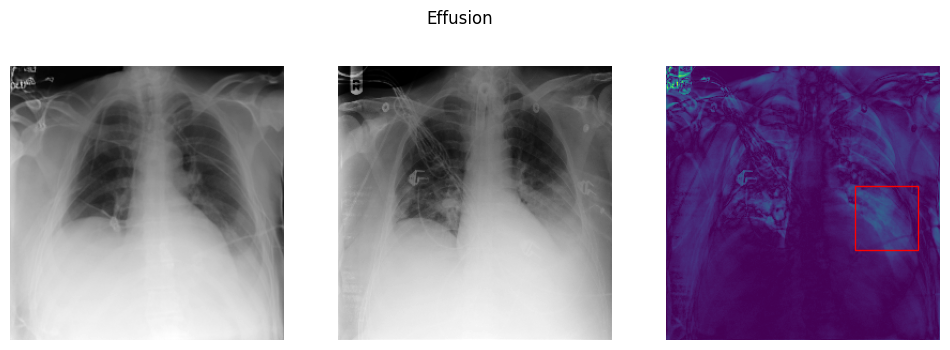

In [35]:
idx_from_batch = 0

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


# Plot the images on the subplots
denoised_guided = x_samples.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_original.cpu()[idx_from_batch].permute(1,2,0)
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle patch to the plot
axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')

fig.suptitle(ret[3][0][idx_from_batch])



In [36]:
model.parameterization

'eps'